### **Loading in Data**

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sklearn as sk
import os

NBHDS_PATH = os.path.join("data", "Neighbourhoods.geojson")
NBHD_PROFILES_PATH = os.path.join("data", "neighbourhood_profiles.csv")
RENT_LISTINGS_PATH = os.path.join("data", "rent_data.csv")

In [4]:
# Load in neighbourhood boundaries data
nbhds_df = gpd.read_file(NBHDS_PATH)
nbhds_df = nbhds_df[['AREA_SHORT_CODE', 'AREA_NAME', 'geometry']]
nbhds_df.head()

,AREA_SHORT_CODE,AREA_NAME,geometry
0,94,Wychwood (94),"POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
1,100,Yonge-Eglinton (100),"POLYGON ((-79.41096 43.70408, -79.40962 43.704..."
2,97,Yonge-St.Clair (97),"POLYGON ((-79.39119 43.68108, -79.39141 43.680..."
3,27,York University Heights (27),"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
4,31,Yorkdale-Glen Park (31),"POLYGON ((-79.43969 43.70561, -79.44011 43.705..."


In [476]:
# Load in neighbourhood profiles data
nbhd_profile_df = pd.read_csv(NBHD_PROFILES_PATH)

# We can drop this since we will have duplicates after joining
nbhd_profile_df = nbhd_profile_df.drop("AREA_NAME", axis=1)
nbhd_profile_df.head()

,AREA_SHORT_CODE,Average Total Income,Median Age,Average Household Size,Total private dwellings,Average Commute Time,"Car, truck, van - as a driver %","Car, truck, van - as a passenger %",Public transit %,Walked %,Bicycle %,Single-detached house %,Apartment in a building w/ >= 5 stories %,Semi-detached house %,Row house %,Apartment or flat in a duplex %,Apartment in a building w/ < 5 stories %,"No certificate, diploma or degree",Secondary (high) school diploma or equivalent,"Postsecondary certificate, diploma or degree"
0,-1,52268.0,41.263313,2.42,1179057,36.127828,0.459816,0.045697,0.370088,0.086059,0.027461,0.242311,0.443222,0.063998,0.055376,0.043615,0.148823,0.102774,0.203934,0.693288
1,129,30414.0,41.263313,3.16,9371,37.403553,0.605330,0.078680,0.283418,0.022420,0.005922,0.366575,0.232329,0.088219,0.157808,0.070685,0.080548,0.215788,0.274345,0.509220
2,128,31825.0,41.263313,2.88,8535,37.102905,0.603839,0.065453,0.293799,0.027559,0.003445,0.342963,0.386601,0.040565,0.063307,0.085433,0.074985,0.141337,0.259119,0.599924
3,20,47709.0,41.226901,2.60,4732,32.496278,0.676592,0.058726,0.212572,0.032258,0.010753,0.614719,0.055195,0.117965,0.018398,0.071429,0.121212,0.114060,0.261836,0.624103
4,95,112766.0,41.956359,1.80,18109,29.250923,0.220657,0.019450,0.415828,0.214621,0.112341,0.040477,0.512394,0.074365,0.037339,0.028553,0.300910,0.025119,0.114987,0.859336


In [6]:
# Load in rent prices data matrix
rent_df = pd.read_csv(RENT_LISTINGS_PATH)
rent_df.head()

,lng,lat,Bedrooms,Bathrooms,Size,Balcony,Dishwasher,In Unit Laundry,On Site Laundry,Assigned Parking,Fitness Center,Garage Parking,Storage,Concierge Service,Swimming Pool,Price
0,-79.392705,43.691986,2.0,1.0,NaN,1,1,0,2,0,0,1,0,0,0,2495.0
1,-79.392705,43.691986,3.0,11.0,NaN,1,1,0,2,0,0,1,0,0,0,3295.0
2,-79.276695,43.699518,0.0,1.0,482.0,1,1,0,2,1,0,1,0,0,0,1731.0
3,-79.276695,43.699518,1.0,1.0,653.0,1,1,0,2,1,0,1,0,0,0,1835.0
4,-79.340810,43.707311,1.0,1.0,554.0,0,1,0,2,0,1,0,1,1,1,1550.0


### **Building the Data Matrix**


First, we will join the dataframe of neighbourhood boundaries and the dataframe of neighbourhood profiles:

In [478]:
nbhd_df = pd.merge(nbhds_df, nbhd_profile_df, how='inner', on='AREA_SHORT_CODE', validate='1:1')

# Write to csv for later use in training
NBHD_PATH = os.path.join("data", "nbhd_final.geojson")
nbhd_df.to_file(NBHD_PATH, driver="GeoJSON")
nbhd_df.head()

,AREA_SHORT_CODE,AREA_NAME,geometry,Average Total Income,Median Age,Average Household Size,Total private dwellings,Average Commute Time,"Car, truck, van - as a driver %","Car, truck, van - as a passenger %",...,Bicycle %,Single-detached house %,Apartment in a building w/ >= 5 stories %,Semi-detached house %,Row house %,Apartment or flat in a duplex %,Apartment in a building w/ < 5 stories %,"No certificate, diploma or degree",Secondary (high) school diploma or equivalent,"Postsecondary certificate, diploma or degree"
0,94,Wychwood (94),"POLYGON ((-79.43592 43.68015, -79.43492 43.680...",54460.0,41.263313,2.24,6185,35.127466,0.332070,0.029568,...,0.092494,0.156330,0.220051,0.149533,0.049278,0.067120,0.353441,0.081491,0.173089,0.745420
1,100,Yonge-Eglinton (100),"POLYGON ((-79.41096 43.70408, -79.40962 43.704...",89330.0,41.263313,2.08,6103,33.442291,0.331929,0.026116,...,0.024431,0.246696,0.351542,0.081938,0.010573,0.054626,0.254626,0.018802,0.094708,0.885794
2,97,Yonge-St.Clair (97),"POLYGON ((-79.39119 43.68108, -79.39141 43.680...",114174.0,41.263313,1.76,7475,31.509449,0.323089,0.024429,...,0.024429,0.074127,0.615110,0.064148,0.031361,0.018532,0.195296,0.018919,0.121622,0.859459
3,27,York University Heights (27),"POLYGON ((-79.50529 43.75987, -79.50488 43.759...",29958.0,41.956359,2.71,11051,39.050039,0.464816,0.051994,...,0.008991,0.121376,0.541032,0.133661,0.076167,0.027518,0.097789,0.149440,0.255102,0.595787
4,31,Yorkdale-Glen Park (31),"POLYGON ((-79.43969 43.70561, -79.44011 43.705...",38527.0,41.263313,2.62,5847,34.743769,0.499221,0.055296,...,0.004673,0.405051,0.221703,0.014967,0.112254,0.086997,0.155285,0.165453,0.279947,0.553938


Now, we will have to (spatially) join our new neighbourhood dataframe with the rent dataframe to obtain neighbourhood profile information for each listing in the rent dataframe:

In [12]:
# Convert to rent data to geopandas df so we can use spatial join 
rent_df_geo = gpd.GeoDataFrame(
    rent_df, geometry=gpd.points_from_xy(rent_df.lng, rent_df.lat))
rent_df_geo = rent_df_geo[rent_df_geo['lat'].notna()] # Remove points that have no coordinates
rent_df_geo.set_crs(epsg=4326)

# Join on geometry
data_matrix = gpd.sjoin(rent_df_geo, nbhd_df, how='left')
data_matrix.head()

/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  


,lng,lat,Bedrooms,Bathrooms,Size,Balcony,Dishwasher,In Unit Laundry,On Site Laundry,Assigned Parking,...,Bicycle %,Single-detached house %,Apartment in a building w/ >= 5 stories %,Semi-detached house %,Row house %,Apartment or flat in a duplex %,Apartment in a building w/ < 5 stories %,"No certificate, diploma or degree",Secondary (high) school diploma or equivalent,"Postsecondary certificate, diploma or degree"
0,-79.392705,43.691986,2.0,1.0,NaN,1,1,0,2,0,...,0.036071,0.243902,0.496765,0.048283,0.025884,0.034345,0.149826,0.018357,0.106471,0.874713
1,-79.392705,43.691986,3.0,11.0,NaN,1,1,0,2,0,...,0.036071,0.243902,0.496765,0.048283,0.025884,0.034345,0.149826,0.018357,0.106471,0.874713
2,-79.276695,43.699518,0.0,1.0,482.0,1,1,0,2,1,...,0.007028,0.198864,0.601326,0.026515,0.037879,0.083333,0.047348,0.145013,0.259843,0.595801
3,-79.276695,43.699518,1.0,1.0,653.0,1,1,0,2,1,...,0.007028,0.198864,0.601326,0.026515,0.037879,0.083333,0.047348,0.145013,0.259843,0.595801
4,-79.340810,43.707311,1.0,1.0,554.0,0,1,0,2,0,...,0.007829,0.000000,0.934081,0.000000,0.011921,0.000000,0.052595,0.147957,0.225928,0.626585


In [18]:
# Remove points that are not in the City of Toronto
data_matrix = data_matrix[data_matrix['AREA_NAME'].notna()]
# data_matrix = data_matrix.drop(['index_right', 'AREA_SHORT_CODE'])

KeyError: "['index_right' 'AREA_SHORT_CODE'] not found in axis"

In [19]:
# Write to geojson (need geometry column to be preserved for mapping purposes)
DF_FINAL_PATH = os.path.join('data', 'rent_final.geojson')
data_matrix.to_file(DF_FINAL_PATH, driver="GeoJSON")

### **Data Exploration**

In [287]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os

# Load in data from geojson
DF_FINAL_PATH = os.path.join('data', 'rent_final.geojson')
data_matrix = gpd.read_file(DF_FINAL_PATH)
data_matrix.head()

,lng,lat,Bedrooms,Bathrooms,Size,Balcony,Dishwasher,In Unit Laundry,On Site Laundry,Assigned Parking,...,Single-detached house %,Apartment in a building w/ >= 5 stories %,Semi-detached house %,Row house %,Apartment or flat in a duplex %,Apartment in a building w/ < 5 stories %,"No certificate, diploma or degree",Secondary (high) school diploma or equivalent,"Postsecondary certificate, diploma or degree",geometry
0,-79.392705,43.691986,2.0,1.0,NaN,1,1,0,2,0,...,0.243902,0.496765,0.048283,0.025884,0.034345,0.149826,0.018357,0.106471,0.874713,POINT (-79.39270 43.69199)
1,-79.392705,43.691986,3.0,11.0,NaN,1,1,0,2,0,...,0.243902,0.496765,0.048283,0.025884,0.034345,0.149826,0.018357,0.106471,0.874713,POINT (-79.39270 43.69199)
2,-79.276695,43.699518,0.0,1.0,482.0,1,1,0,2,1,...,0.198864,0.601326,0.026515,0.037879,0.083333,0.047348,0.145013,0.259843,0.595801,POINT (-79.27669 43.69952)
3,-79.276695,43.699518,1.0,1.0,653.0,1,1,0,2,1,...,0.198864,0.601326,0.026515,0.037879,0.083333,0.047348,0.145013,0.259843,0.595801,POINT (-79.27669 43.69952)
4,-79.340810,43.707311,1.0,1.0,554.0,0,1,0,2,0,...,0.000000,0.934081,0.000000,0.011921,0.000000,0.052595,0.147957,0.225928,0.626585,POINT (-79.34081 43.70731)


In [2]:
data_matrix.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9037 entries, 0 to 9036
Data columns (total 39 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   lng                                            9037 non-null   float64 
 1   lat                                            9037 non-null   float64 
 2   Bedrooms                                       9037 non-null   float64 
 3   Bathrooms                                      9006 non-null   float64 
 4   Size                                           2813 non-null   float64 
 5   Balcony                                        9037 non-null   int64   
 6   Dishwasher                                     9037 non-null   int64   
 7   In Unit Laundry                                9037 non-null   int64   
 8   On Site Laundry                                9037 non-null   int64   
 9   Assigned Parking                 

Notice that there are 31 data points with a null bathroom value, so we should take those out:

In [288]:
data_matrix = data_matrix[data_matrix['Bathrooms'].notna()]

# Removing points in certain neighbourhoods so that we can use stratified splitting
remove_nbhds = [3.0, 5.0, 133.0, 21.0]
data_matrix = data_matrix[~data_matrix["AREA_SHORT_CODE"].isin(remove_nbhds)]

# Make 'Laundry' feature into one hot vector
data_matrix['On Site Laundry'] = data_matrix[['On Site Laundry']].replace({2: 1})

# Make 'Price' values in 1000s ($)
data_matrix['Price'] = data_matrix['Price'] / 1000

# Remove outliers and fix data collection mistakes
data_matrix.drop(index=2663, inplace=True) # Listing error
data_matrix.drop(index=2752, inplace=True) # Parsing error
data_matrix.loc[data_matrix.index == 6006, 'Price'] = 9.5 # Update listing; parsing error
data_matrix['Bathrooms'] = data_matrix[['Bathrooms']].replace({11: 1, 21: 2}) # Parsing error: 11 -> 1, 21 -> 2

#### Price Distribution by Number of Bedrooms

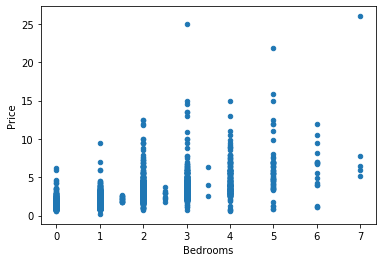

In [312]:
data_matrix[['Bedrooms', 'Price']].plot('Bedrooms', 'Price', kind='scatter')

#### Price Distribution by Neighbourhood

In [20]:
nbhd_counts = data_matrix.groupby('AREA_NAME').count()['lat']
nbhd_counts.sort_values(ascending=False)[:10]

AREA_NAME
Waterfront Communities-The Island (77)      1567
Bay Street Corridor (76)                     627
Church-Yonge Corridor (75)                   625
Niagara (82)                                 532
Mount Pleasant West (104)                    388
Annex (95)                                   335
Willowdale East (51)                         295
Mimico (includes Humber Bay Shores) (17)     259
Moss Park (73)                               251
Kensington-Chinatown (78)                    174
Name: lat, dtype: int64

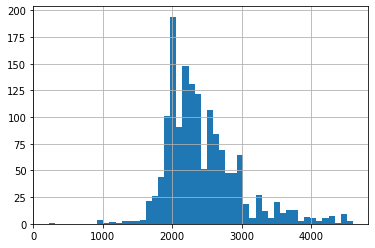

In [21]:
# Neighbourhood with the most listings is Waterfront Communities-The Island (77)
waterfront_prices = data_matrix[data_matrix['AREA_SHORT_CODE'] == 77]['Price']
mu, sigma = waterfront_prices.mean(), waterfront_prices.std()
waterfront_filtered = waterfront_prices[waterfront_prices < mu + 2*sigma]
waterfront_filtered.hist(bins=50)

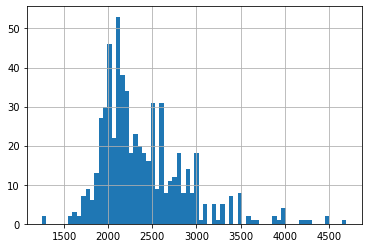

In [23]:
# Second is Bay Street Corridor (76)
bay_st_prices = data_matrix[data_matrix['AREA_SHORT_CODE'] == 76]['Price']
mu, sigma = bay_st_prices.mean(), bay_st_prices.std()
bay_st_filtered = bay_st_prices[bay_st_prices < mu + 2*sigma]
bay_st_filtered.hist(bins=70)

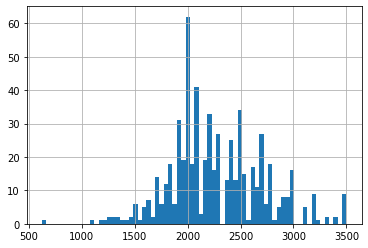

In [24]:
# Third is Church-Yonge Corridor (75)
cy_prices = data_matrix[data_matrix['AREA_SHORT_CODE'] == 75]['Price']
mu, sigma = cy_prices.mean(), cy_prices.std()
cy_filtered = cy_prices[cy_prices < mu + 2*sigma]
cy_filtered.hist(bins=70)

#### Price Distribution by Neighbourhood, Bedrooms

In [27]:
# Waterfront Communities-The Island (77)
data_matrix[data_matrix['AREA_SHORT_CODE'] == 77].groupby('Bedrooms').count()['lng']

Bedrooms
0.0     74
1.0    964
1.5      2
2.0    474
3.0     50
4.0      2
5.0      1
Name: lng, dtype: int64

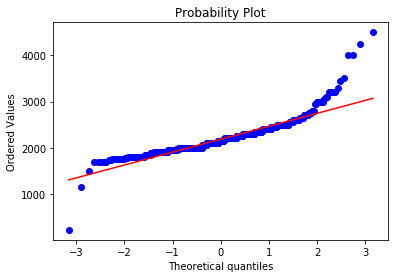

In [24]:
import pylab 
import scipy.stats as stats

waterfront = data_matrix[data_matrix['AREA_SHORT_CODE'] == 77]
mu, sigma = waterfront['Price'].mean(), waterfront['Price'].std()
waterfront = waterfront[waterfront['Price'] < mu + 2*sigma]

# 1 Bedroom, 1 Bathroom
waterfront_prices = waterfront[(waterfront['AREA_SHORT_CODE'] == 77) & (waterfront['Bedrooms'] == 1) & (waterfront['Bathrooms'] == 1)]['Price']
stats.probplot(waterfront_prices, dist="norm", plot=pylab)
pylab.show()

The QQ-plot indicates that the distribution of prices is more heavy-tailed (especially in the right tail) than that of a normal distrbution.

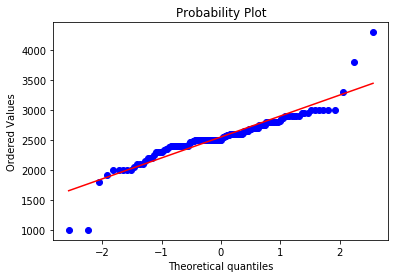

In [50]:
# 2 Bedroom, 1 Bathroom
waterfront_prices = waterfront[(waterfront['AREA_SHORT_CODE'] == 77) & (waterfront['Bedrooms'] == 2) & (waterfront['Bathrooms'] == 1)]['Price']
stats.probplot(waterfront_prices, dist="norm", plot=pylab)
pylab.show()

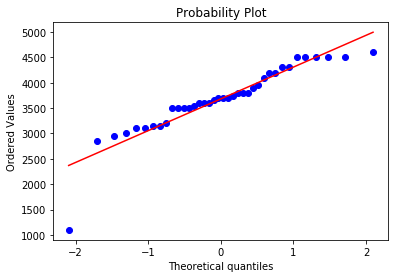

In [51]:
# 3 Bedroom, 1 Bathroom; a somewhat abnormal setting
waterfront_prices = waterfront[(waterfront['AREA_SHORT_CODE'] == 77) & (waterfront['Bedrooms'] == 3) & (waterfront['Bathrooms'] == 2)]['Price']
stats.probplot(waterfront_prices, dist="norm", plot=pylab)
pylab.show()

The QQ-plot suggests there might be some multi-modality (3), and again some heavy-tailedness.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4cdc36a90>,
      dtype=object)

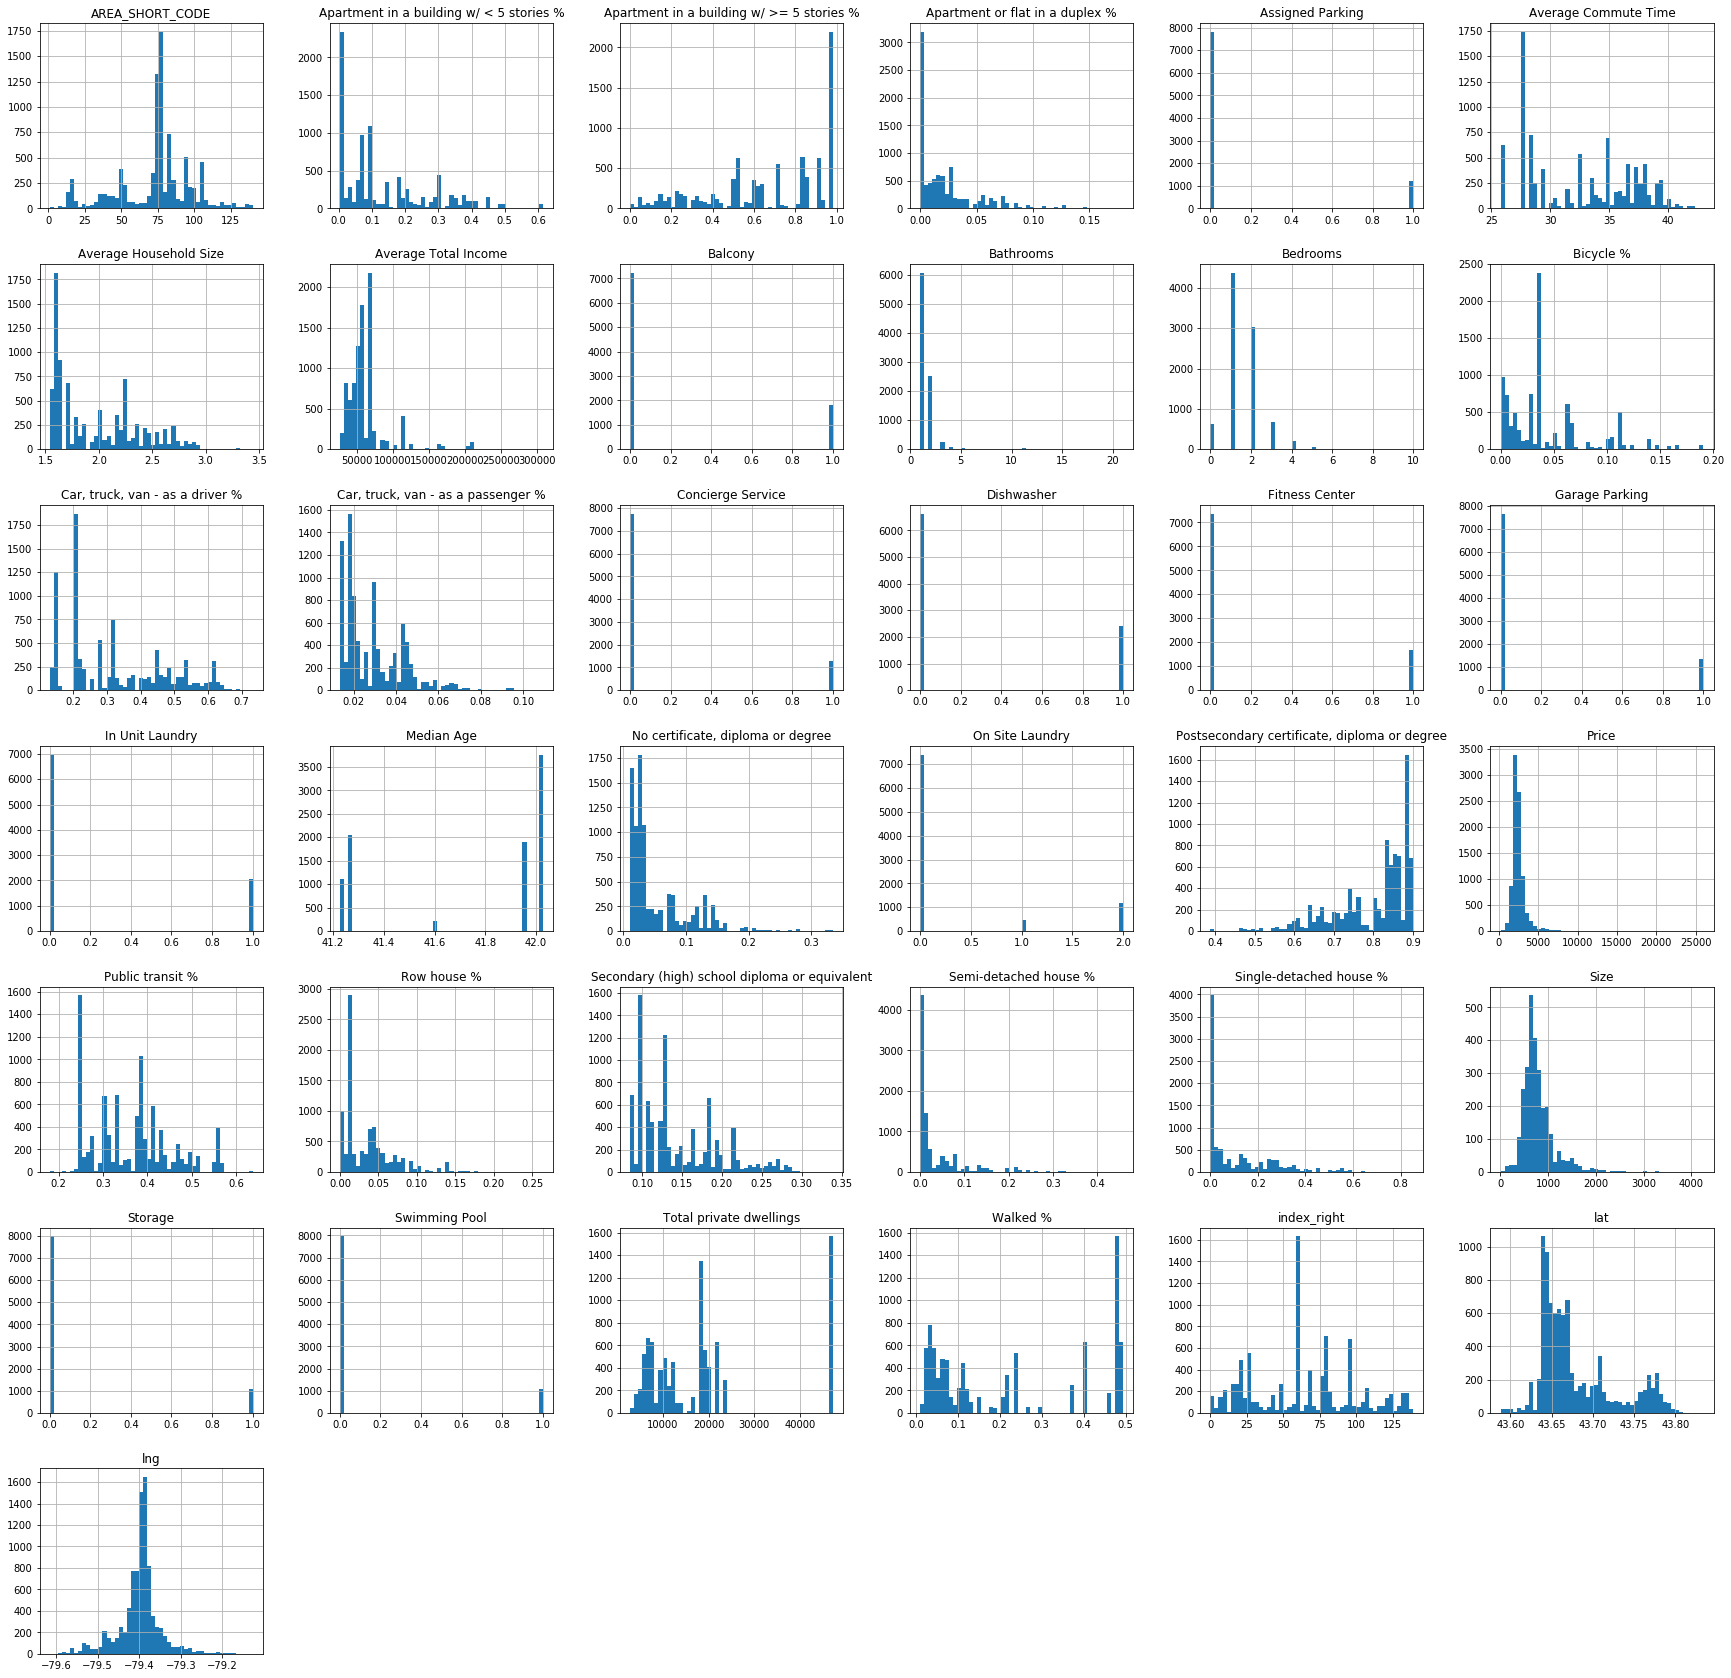

In [55]:
data_matrix.hist(bins=50, figsize=(30,30))

We can see that many of our histograms have a lot of skewness, amounting to the fact that many of the listings come from an areas with a specific demographic (e.g., university/college educated, has high population density, upper-middle class, etc.). This may make it difficult for our model to detect patterns in the populations which lie along the tails, resulting in sub-optimal predictions. We compare to the city-wide demographics:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4cd9f4f90>,
      dtype=object)

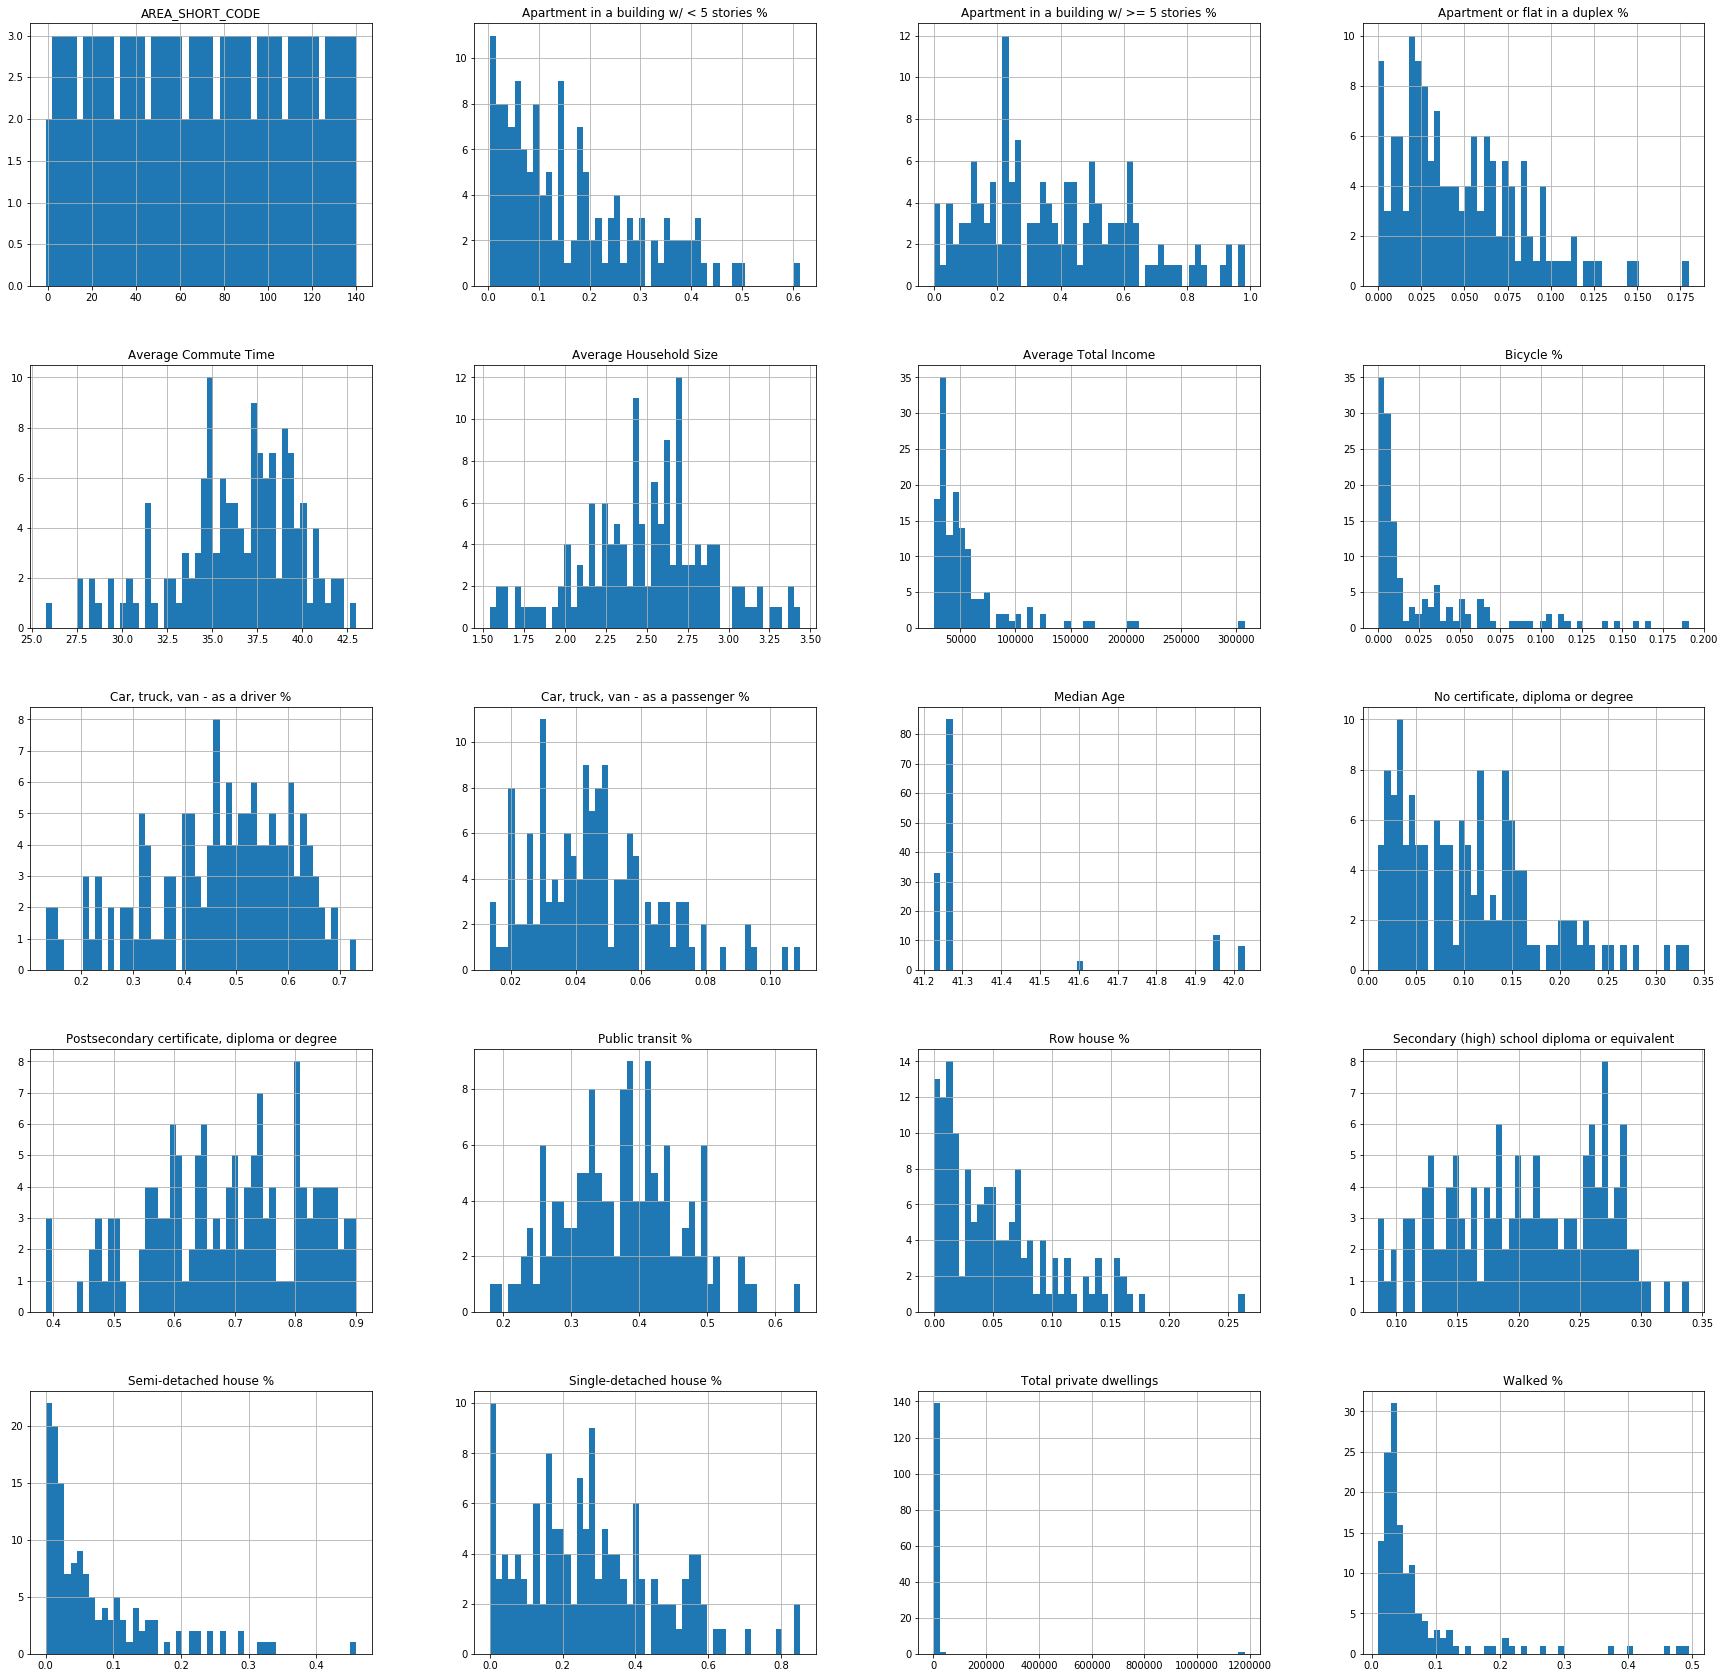

In [60]:
nbhd_profile_df.hist(bins=50, figsize=(30,30))

### **Train/Test Split**

In [313]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size=0.15, random_state=69)
for train_idx, test_idx in split.split(data_matrix, data_matrix[['AREA_SHORT_CODE']]):
    training_set = data_matrix.iloc[train_idx]
    test_set = data_matrix.iloc[test_idx]

We can check the coverage of our training set:

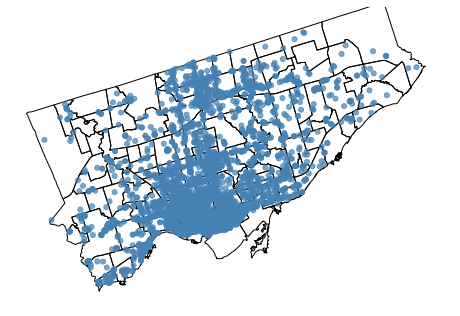

In [9]:
import geoplot


ax = geoplot.polyplot(nbhds_df['geometry'], projection=geoplot.crs.WebMercator())
geoplot.pointplot(training_set['geometry'], ax=ax, alpha=0.7)

In [26]:
corr_matrix = training_set.corr()
corr_matrix['Price'].sort_values(ascending=False)

Price                                            1.000000
Size                                             0.703283
Bedrooms                                         0.584033
Bathrooms                                        0.448912
Average Total Income                             0.177837
Postsecondary certificate, diploma or degree     0.120965
Single-detached house %                          0.077634
Bicycle %                                        0.032650
lat                                              0.030485
Car, truck, van - as a driver %                  0.025719
In Unit Laundry                                  0.022309
Average Household Size                           0.016627
Walked %                                         0.016563
Assigned Parking                                 0.015114
Apartment in a building w/ < 5 stories %         0.002541
Median Age                                       0.000539
Total private dwellings                          0.000271
Dishwasher    

So far, it looks like attributes with an absolute correlation score less than ~0.0365 (i.e., $|r| < 0.0365$), with the exception of longitude and latitude, will not be very useful, as it seems AREA_SHORT_CODE provides a stronger signal than these attributes, even though AREA_SHORT_CODE is a random attribute. We can use a 

In [27]:
from pandas.plotting import scatter_matrix
import seaborn as sns

# Room listing attributes
attributes = ['Price', 'Size', 'Bedrooms', 'Bathrooms', 'Dishwasher', 'On Site Laundry', 'Fitness Center', 'Storage', 'Swimming Pool']
corr_matrix = training_set1[attributes].corr(method='kendall')
ax = sns.heatmap(corr_matrix, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

NameError: name 'training_set1' is not defined

AttributeError: 'QuadMesh' object has no property 'figsize'

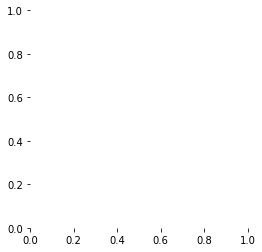

In [29]:
# Neighbourhood attributes
attributes = [
    'Price',
    'Average Total Income',
    'Median Age',
    'Average Household Size',
    'Total private dwellings',
    'Average Commute Time', 
    'Car, truck, van - as a driver %', 
    'Car, truck, van - as a passenger %',
    'Public transit %', 
    'Walked %', 
    'Bicycle %', 
    'Single-detached house %', 
    'Apartment in a building w/ >= 5 stories %', 
    'Semi-detached house %', 
    'Row house %', 
    'Apartment or flat in a duplex %', 
    'Apartment in a building w/ < 5 stories %', 
    'No certificate, diploma or degree', 
    'Secondary (high) school diploma or equivalent', 
    'Postsecondary certificate, diploma or degree'
]
corr_matrix = training_set[attributes].corr(method='kendall')
ax = sns.heatmap(corr_matrix, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True, figsize=(20, 20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

[Text(0.5, 0, 'Price'),
 Text(1.5, 0, 'Average Total Income'),
 Text(2.5, 0, 'Median Age'),
 Text(3.5, 0, 'Average Household Size'),
 Text(4.5, 0, 'Total private dwellings'),
 Text(5.5, 0, 'Average Commute Time')]

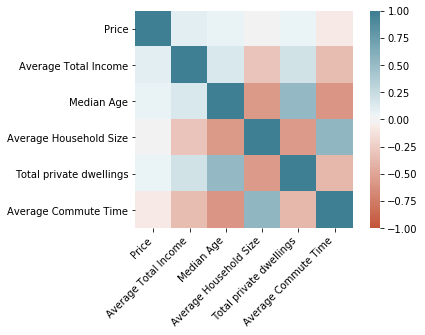

In [108]:
attributes = [
    'Price',
    'Average Total Income',
    'Median Age',
    'Average Household Size',
    'Total private dwellings',
    'Average Commute Time', 
]
corr_matrix = training_set[attributes].corr(method='kendall')
ax = sns.heatmap(corr_matrix, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

### **Data Cleaning**

In [314]:
X_train = training_set.drop('Price', axis=1)
y_train = training_set['Price'].copy()
X_test = test_set.drop('Price', axis=1)
y_test = test_set['Price'].copy()

In [382]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

one_hot_attribs = [
    'Balcony', 
    'Dishwasher',
    'In Unit Laundry',
    'On Site Laundry',
    'Assigned Parking',
    'Fitness Center',
    'Garage Parking',
    'Storage',
    'Concierge Service',
    'Swimming Pool'
]

num_attribs = list(set(X_train.columns).difference(set(one_hot_attribs)))

class SizeImputer(KNNImputer):
    def __init__(self, n_neighbors=5):
        # Features to base imputation on
        self.cols = ['Size', 'Bedrooms', 'Bathrooms', 'lng', 'lat']
        super().__init__(n_neighbors=n_neighbors, copy=True)
        
    def fit(self, X, y=None):
        tr_X = X[self.cols]
        return super().fit(tr_X)
    
    def transform(self, X):
        tr_X = X[self.cols]
        X[['Size']] = super().transform(tr_X)[:, 0]
        return X
    
class FeatureDropper(BaseEstimator, TransformerMixin):
    # For dropping extra attributes and fixing Laundry attribute
    def __init__(self, dwellings=False, education=False, commute=False, pvt_dwellings=False, m_age=False):
        self.dwellings = dwellings
        self.education = education
        self.commute = commute
        self.pvt_dwellings = pvt_dwellings
        self.m_age = m_age
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.drop(['index_right', 'AREA_SHORT_CODE', 'AREA_NAME', 'geometry'], axis=1)
        if self.dwellings:
            X = X.drop([
                'Single-detached house %',  
                'Semi-detached house %', 
                'Row house %', 
                'Apartment or flat in a duplex %', 
                'Apartment in a building w/ < 5 stories %',
            ], axis=1)
        if self.education:
            X = X.drop([
                'No certificate, diploma or degree', 
                'Secondary (high) school diploma or equivalent', 
            ], axis=1)
        if self.commute:
            X = X.drop([
                'Car, truck, van - as a driver %', 
                'Car, truck, van - as a passenger %',
            ], axis=1)
        if self.pvt_dwellings:
            X = X.drop(['Total private dwellings'], axis=1)
        if self.m_age:
            X = X.drop(['Median Age'], axis=1)
        return X

num_pipeline = Pipeline([
    ('size_imputer', SizeImputer(n_neighbors=5)),
    ('feature_dropper', FeatureDropper(
        dwellings=True, 
        education=True, 
        commute=True,
        pvt_dwellings=True, 
        m_age=True
    )),
    ('std_scaler', StandardScaler())
])

data_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', 'passthrough', one_hot_attribs)
])


Before training our models, we can do a quick run of Linear Regression (OLS) and compute the Variance Inflation Factor (VIF) for each factor to detect multicollinearity. Since multicollinearity makes the variance of the regression coefficients large, VIF measures how much the variance has increased due to collinearity.

In [322]:
remove_cols = ['index_right', 'AREA_SHORT_CODE', 'AREA_NAME', 'geometry']
X_cols = [col for col in X_train.columns if not col in remove_cols]
X_cols

['lng',
 'lat',
 'Bedrooms',
 'Bathrooms',
 'Size',
 'Balcony',
 'Dishwasher',
 'In Unit Laundry',
 'On Site Laundry',
 'Assigned Parking',
 'Fitness Center',
 'Garage Parking',
 'Storage',
 'Concierge Service',
 'Swimming Pool',
 'Average Total Income',
 'Median Age',
 'Average Household Size',
 'Total private dwellings',
 'Average Commute Time',
 'Car, truck, van - as a driver %',
 'Car, truck, van - as a passenger %',
 'Public transit %',
 'Walked %',
 'Bicycle %',
 'Single-detached house %',
 'Apartment in a building w/ >= 5 stories %',
 'Semi-detached house %',
 'Row house %',
 'Apartment or flat in a duplex %',
 'Apartment in a building w/ < 5 stories %',
 'No certificate, diploma or degree',
 'Secondary (high) school diploma or equivalent',
 'Postsecondary certificate, diploma or degree']

In [324]:
# Make a similar pipeline as above but without feature standardization
num_vif_pipeline = Pipeline([
    ('size_imputer', SizeImputer(n_neighbors=5)),
    ('feature_dropper', FeatureDropper()),
])

vif_pipeline = ColumnTransformer([
    ('num', num_vif_pipeline, num_attribs),
    ('cat', 'passthrough', one_hot_attribs)
])

X_vif = vif_pipeline.fit_transform(X_train)

# Calculate VIF
def variance_inflation_factor(X):
    cc = np.corrcoef(X, rowvar=False)
    VIF = np.linalg.inv(cc)
    return VIF.diagonal()

VIF = variance_inflation_factor(X_vif)

# Display factors with VIF > 10 (high multicollinearity)
# X_cols = np.asarray(list(set(X_train.columns).difference(set(['index_right', 'AREA_SHORT_CODE', 'AREA_NAME', 'geometry']))))
X_cols = np.array([col for col in X_train.columns if col not in ['index_right', 'AREA_SHORT_CODE', 'AREA_NAME', 'geometry']])
v_inf_cols = X_cols[VIF > 10]
v_inf_vals = VIF[VIF > 10]
for i in range(len(v_inf_cols)):
    print(f'{v_inf_cols[i]}: {v_inf_vals[i]:0.2f}')

Bedrooms: 34171.92
Bathrooms: 9252.36
Size: 1767.25
Dishwasher: 8335.99
In Unit Laundry: 1990.29
On Site Laundry: 5538.84
Assigned Parking: 12.21
Storage: 8850.26
Concierge Service: 111.53
Swimming Pool: 2063.92
Average Total Income: 91.97
Average Household Size: 27.09
Total private dwellings: 8017.01
Average Commute Time: 343.76
Public transit %: 394.93
Walked %: 61.27


As we can see, the VIF score for a number of features is extremely high, suggesting that there exists strong multicollinearity among our features. We generally want to remove correlated features since:
- We want a simpler model. We should remove features that do not provide more information during training.
- In certain models, training becomes more difficult. In (unregularized) linear regression, the resulting model will exhibit coefficients that are extremely large in magnitude and in some cases, will have the wrong sign, which will affect the model's ability to generalize. In tree-based models, the model will choose to ignore features that are highly correlated with others, which will make training more inefficient.

Let's remove some features to see if the scores improve:

In [325]:
dropped_cols = [
    'Single-detached house %',  
    'Semi-detached house %', 
    'Row house %', 
    'Apartment or flat in a duplex %', 
    'Apartment in a building w/ < 5 stories %',
    'No certificate, diploma or degree', 
    'Secondary (high) school diploma or equivalent',
    'Car, truck, van - as a driver %', 
    'Car, truck, van - as a passenger %',
    'Total private dwellings',
    'Median Age',
    'index_right', 
    'AREA_SHORT_CODE', 
    'AREA_NAME', 
    'geometry'
]

num_vif_pipeline = Pipeline([
    ('size_imputer', SizeImputer(n_neighbors=5)),
    ('feature_dropper', FeatureDropper(dwellings=True, education=True, commute=True, pvt_dwellings=True, m_age=True)),
])
vif_pipeline = ColumnTransformer([
    ('num', num_vif_pipeline, num_attribs),
    ('cat', 'passthrough', one_hot_attribs)
])

X_vif = vif_pipeline.fit_transform(X_train)
VIF = variance_inflation_factor(X_vif)

# Display factors with VIF > 5 (high multicollinearity)
X_cols = np.array([col for col in X_train.columns if col not in dropped_cols])
v_inf_cols = X_cols[VIF > 5]
v_inf_vals = VIF[VIF > 5]
for i in range(len(v_inf_cols)):
    print(f'{v_inf_cols[i]}: {v_inf_vals[i]:0.2f}')

Size: 26.64
Dishwasher: 9.04
Assigned Parking: 20.31
Fitness Center: 6.91


For now, we'll keep these features and see how important they are to the models during inference, at which point we can choose to remove them.

In [383]:
X_train_final = data_pipeline.fit_transform(X_train)

### **Training the Model**

In [328]:
# Scores of various training algorithms
scores = {
    'Multiple Regressors': {},
    'NN w/ Monte Carlo Dropout': {},
    'NGB w/ Decision Tree WL': {},
    'NGB w/ Ridge Regression WL': {},
    'Gaussian Process': {}
}

In [329]:
from sklearn.model_selection import train_test_split
from scipy.stats import norm

class DistributionEstimator(BaseEstimator):
    # A multi-output regressor that uses two regressors two learn
    # mu and sigma for price ~ N(mu, sigma)
    
    def __init__(self, mu_estimator, sigma2_estimator):
        self.mu_estimator = mu_estimator
        self.sigma2_estimator = sigma2_estimator
    
    def fit(self, X, y):
        X_mean, X_sd, y_mean, y_sd = train_test_split(X, y, test_size=0.5)
        self.mu_estimator.fit(X_mean, y_mean)
        mean_pred = self.mu_estimator.predict(X_sd)
        # Train on log((y - yhat)^2) to force positive values
        sq_resid = np.log((mean_pred - y_sd) ** 2) 
        self.sigma2_estimator.fit(X_sd, sq_resid)
        return self
        
    def predict(self, X):
        mu = self.mu_estimator.predict(X)
        sigma_sq = np.exp(self.sigma2_estimator.predict(X))
        sigma = np.sqrt(sigma_sq)
        return norm(loc=mu, scale=sigma)
    
    def mu_estimator_():
        return self.mu_estimator
    
    def sigma2_estimator_():
        return self.sigma2_estimator

# Scoring function for above estimator: log-likelihood under Gaussian
def log_likelihood(estimator, X, y):
    # Assumes estimator.predict returns a frozen scipy.stats.norm object
    preds = estimator.predict(X)
    log_lls = -np.log(preds.pdf(y))
    return np.mean(log_lls)
        

In [330]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score

mu_estimator = GradientBoostingRegressor(max_features='sqrt')
sigma2_estimator = GradientBoostingRegressor(max_features='sqrt')
dist_model = DistributionEstimator(mu_estimator, sigma2_estimator)

In [331]:
t_scores = cross_val_score(dist_model, X_train_final, y_train,
                        scoring=log_likelihood, cv=7)
scores['Multiple Regressors'] = {
    'mean': t_scores.mean(),
    'std': t_scores.std()
}

#### Neural Network (Monte Carlo Dropout)

In [337]:
import torch
from torch import nn
from torch.distributions.normal import Normal
from torch import optim
from scipy.stats import norm
from scipy.special import logsumexp

class MCDropout(nn.Module):
    """
    Defines the architecture of a fully connected network with a single hidden
    layer w/ tanh non-linearity, with negative gaussian log-likelihood objective.
    """
    
    def __init__(self, in_dim, hidd_dim=128, non_linearity='tanh', drop_rate=0.2, tau=1.0):
        super(MCDropout, self).__init__()
        self.drop_rate = drop_rate
        self.dropout1 = nn.Dropout(p=drop_rate)
        self.pre_hidd_layer = nn.Linear(in_features=in_dim, out_features=hidd_dim)
        activations = {
            'tanh': nn.Tanh,
            'logistic': nn.Sigmoid,
            'relu': nn.ReLU
         }
        self.activation = activations[non_linearity]()
        self.dropout2 = nn.Dropout(p=drop_rate)
        self.out_layer = nn.Linear(in_features=hidd_dim, out_features=1)
        self.tau = tau # Model precision; used for regularization (i.e., y | f ~ N(f, tau^-1 * I))
        
    def forward(self, x):
        """
        Produces an N-dimensional vector given a batch of 
        (in_dim)-dimensional vectors.
        
        Input
        _____
        x: BS x in_dim
        
        Output
        ______
        out: BS x 1
        """
        x = self.dropout1(x)
        x = self.pre_hidd_layer(x)
        x = self.activation(x)
        x = self.dropout2(x)
        return self.out_layer(x)
    
    def fit(self, train_X, train_y, val_X=None, val_y=None, n_batches=6, n_epochs=100):
        """
        Backpropogate through layers to find the optimal model
        parameters that minimizes maximizes the negative gaussian log-likelihood.
        test_X and test_y are a hold-out set for which we evaluate the model's training.
        """
        
        # Convert numpy arrays to tensors
        train_X = torch.from_numpy(train_X).float()
        train_y = torch.from_numpy(train_y).float()
        if val_X is not None and val_y is not None:
            val_X = torch.from_numpy(val_X).float()
            val_y = torch.from_numpy(val_y).float()
        
        # Weight penalty
        N = train_X.size()[0]
        lengthscale = 1e-2
        reg = lengthscale**2 * self.drop_rate / (2. * N * self.tau)
        
        batch_size = int(np.floor(N / n_batches))
        optimizer = optim.Adam(self.parameters(), weight_decay=reg)
        
        # Set model to training mode to turn on dropout layers
        self.train()
        
        for i in range(n_epochs):
            for batch_i in range(n_batches + 1):
                
                # Subsample mini-batch from training set
                if batch_i != n_batches:
                    idx = slice(batch_i * batch_size, (batch_i + 1) * batch_size)
                else:
                    idx = slice(batch_i * batch_size, train_X.size()[0])
                objective = self.objective(train_X[idx, :], train_y[idx])
                
                # Compute gradients and take gradient step
                optimizer.zero_grad()
                objective.backward()
                optimizer.step()
            
            if val_X is not None and ((i + 1) % 10 == 0):
                print(f'Test loss at epoch [{i + 1}/{n_epochs}]: {self.objective(val_X, val_y)}')
                
    def mc_predict(self, X, T=1000):
        """
        Make T draws from the posterior predictive distribution.
        """
        
        X = torch.from_numpy(X).float()

        # Set to evaluation mode
        self.eval()
        # KEEP DROPOUT ON DURING EVALUATION MODE
        self.dropout1.train()
        self.dropout2.train()
        
        # Make T draws from posterior predictive distribution
        y_hat = np.array([self.forward(X).detach().numpy() for _ in range(T)])
        if y_hat.shape[-1] == 1:
            y_hat = y_hat.squeeze()
        
        return y_hat
    
    def _predict(self, X):
        """
        Make single prediction with dropout layers turned off.
        """
        X = torch.from_numpy(X).float()

        # Set to evaluation mode
        self.eval()
        y_hat = self.forward(X).detach().numpy()
        
        # Convert float64 to satisfy shap
        return y_hat.astype(np.float64)
        
    def objective(self, xs, ys):
        y_pred = self.forward(xs).squeeze()
        ys = ys.squeeze()
        if (ys.size() != y_pred.size()):
            print(f'Prediction size: {y_pred.size()}, Target size: {ys.size()}')
        return torch.nn.MSELoss(reduction='sum')(y_pred, ys)
    
    def negative_log_likelihood(self, test_X, test_y, T=500):
        """
        Return the negative log-likelihood for each instance in test_X.
        """
        preds = self.mc_predict(test_X, T=T)
        nll = -(logsumexp(-0.5 * self.tau * (test_y[None] - preds)**2., 0) - np.log(T) 
            - 0.5*np.log(2*np.pi) + 0.5*np.log(self.tau))
        return nll
    
    def score(self, test_X, test_y, T=500):
        """
        Return the average negative log-likelihood over all instances in test_X.
        """
        nll = self.negative_log_likelihood(test_X, test_y, T=T)
        return np.mean(nll)

In [338]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=7)
nn_scores = []

# Convert to Pandas Series to numpy
# y_train = y_train.to_numpy()

for train, test in kf.split(X_train_final):
    mcn = MCDropout(X_train_final.shape[1], hidd_dim=50, drop_rate=0.2, tau=0.9)
    mcn.fit(X_train_final[train, :], y_train[train], n_epochs=700)
    score = mcn.score(X_train_final[test, :], y_train[test], T=500)
    nn_scores.append(score)

nn_scores = np.asarray(nn_scores)
scores['NN w/ Monte Carlo Dropout'] = {
    'mean': nn_scores.mean(),
    'std': nn_scores.std()
}

#### Natural Gradient Boosting (w/ Decision Tree Weak Learner)

In [339]:
from ngboost import NGBRegressor
from sklearn.model_selection import KFold

kf = KFold(n_splits=7)
ngb_scores = []

# Convert to Pandas Series to numpy
# y_train = y_train.to_numpy()

for train, test in kf.split(X_train_final):
    ngb = NGBRegressor(verbose=False)
    ngb.fit(X_train_final[train, :], y_train[train])
    y_dists = ngb.pred_dist(X_train_final[test, :])
    score = -y_dists.logpdf(y_train[test]).mean()
    ngb_scores.append(score)

ngb_scores = np.asarray(ngb_scores)
scores['NGB w/ Decision Tree WL'] = {
    'mean': ngb_scores.mean(),
    'std': ngb_scores.std()
}

overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square


#### Natural Gradient Boosting (w/ Ridge Regression Weak Learner)

In [340]:
from sklearn.linear_model import Ridge

kf = KFold(n_splits=7)
ngb_scores = []

# Convert to Pandas Series to numpy
# y_train = y_train.to_numpy()

for train, test in kf.split(X_train_final):
    learner = Ridge()
    ngb = NGBRegressor(Base=learner, verbose=False)
    ngb.fit(X_train_final[train, :], y_train[train])
    y_dists = ngb.pred_dist(X_train_final[test, :])
    score = -y_dists.logpdf(y_train[test]).mean()
    ngb_scores.append(score)

ngb_scores = np.asarray(ngb_scores)
scores['NGB w/ Ridge Regression WL'] = {
    'mean': ngb_scores.mean(),
    'std': ngb_scores.std()
}

In [342]:
print('Multiple Regressors: {:0.2f} +- {:0.2f}'.format(scores['Multiple Regressors']['mean'], scores['Multiple Regressors']['std']))
print('NN w/ Monte Carlo Dropout: {:0.2f} +- {:0.2f}'.format(scores['NN w/ Monte Carlo Dropout']['mean'], scores['NN w/ Monte Carlo Dropout']['std']))
print('NGB w/ Decision Tree WL: {:0.2f} +- {:0.2f}'.format(scores['NGB w/ Decision Tree WL']['mean'], scores['NGB w/ Decision Tree WL']['std']))
print('NGB w/ Ridge Regression WL: {:0.2f} +- {:0.2f}'.format(scores['NGB w/ Ridge Regression WL']['mean'], scores['NGB w/ Ridge Regression WL']['std']))

Multiple Regressors: 1.91 +- 0.36
NN w/ Monte Carlo Dropout: 1.19 +- 0.07
NGB w/ Decision Tree WL: 0.45 +- 0.08
NGB w/ Ridge Regression WL: 0.64 +- 0.06


### **Model Evaluation**

In [343]:
import shap
from sklearn.model_selection import train_test_split

X_cols = [
   'lng', 
   'lat', 
   'Bedrooms', 
   'Bathrooms', 
   'Size', 
   'Average Total Income', 
   'Average Household Size',
   'Average Commute Time', 
   'Public transit %', 
   'Walked %', 
   'Bicycle %',
   'Apartment in a building w/ >= 5 stories %',
   'Postsecondary certificate, diploma or degree',
   'Balcony', 
   'Dishwasher',
   'In Unit Laundry', 
   'On Site Laundry', 
   'Assigned Parking',
   'Fitness Center', 
   'Garage Parking', 
   'Storage', 
   'Concierge Service',
   'Swimming Pool'
]

# Turn into DataFrame so that we can look at feature behaviours
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.1)
train_X_clean = pd.DataFrame(data_pipeline.fit_transform(train_X), columns=X_cols)
val_X_clean = pd.DataFrame(data_pipeline.fit_transform(val_X), columns=X_cols)

#### Natural Gradient Boosting (w/ Decision Tree Weak Learner)

overflow encountered in square
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


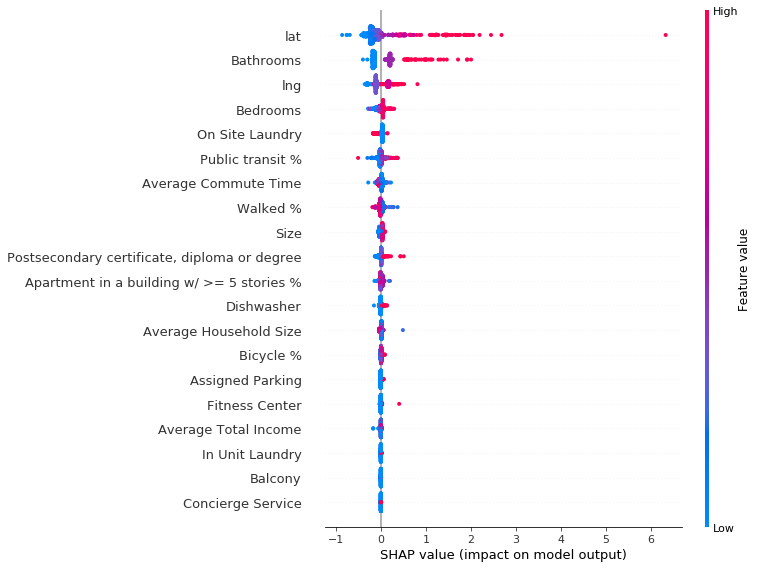

In [344]:
shap.initjs()

ngb = NGBRegressor(verbose=False)
ngb.fit(train_X_clean, train_y)

explainer = shap.TreeExplainer(ngb, model_output=0)
dt_shap_values = explainer.shap_values(val_X_clean)
shap.summary_plot(dt_shap_values, val_X_clean)

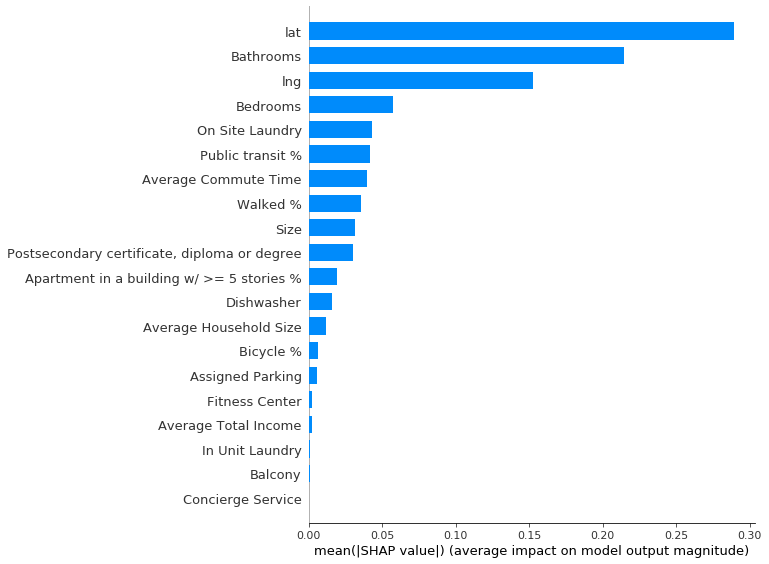

In [345]:
# Feature importance
shap.summary_plot(dt_shap_values, val_X_clean, plot_type="bar")

Let's take a look at a force plot for validation examples for which the model performance is poor, and see the feature contributions for these examples:

In [346]:
# Predict on validation set
y_dists = ngb.pred_dist(val_X_clean)
scores = -y_dists.logpdf(val_y)
top_3_idx = np.flip(np.argsort(scores))[:5]

# Instance with the worst score
idx = top_3_idx[0]
print('Predicted price: {:0.2f}, True price: {}'.format(y_dists[idx].params['loc'], val_y[idx]))
print(val_X.iloc[idx])

# Force plot
shap.force_plot(explainer.expected_value, dt_shap_values[idx,:], val_X_clean.iloc[idx,:])

Predicted price: 5.29, True price: 26.0
lng                                                                            -79.429
lat                                                                            43.7487
Bedrooms                                                                             7
Bathrooms                                                                            8
Size                                                                               NaN
Balcony                                                                              0
Dishwasher                                                                           0
In Unit Laundry                                                                      0
On Site Laundry                                                                      0
Assigned Parking                                                                     0
Fitness Center                                                                       0
Gar

In [347]:
# Instance with the 2nd worst score
idx = top_3_idx[1]
print('Predicted price: {:0.2f}, True price: {}'.format(y_dists[idx].params['loc'], val_y[idx]))
print(val_X.iloc[idx])

# Force plot
shap.force_plot(explainer.expected_value, dt_shap_values[idx,:], val_X_clean.iloc[idx,:])

Predicted price: 2.99, True price: 9.5
lng                                                                            -79.3871
lat                                                                             43.6453
Bedrooms                                                                              2
Bathrooms                                                                             2
Size                                                                                NaN
Balcony                                                                               0
Dishwasher                                                                            0
In Unit Laundry                                                                       0
On Site Laundry                                                                       0
Assigned Parking                                                                      0
Fitness Center                                                                   

In [348]:
# Instance with the 3rd worst score
idx = top_3_idx[2]
print('Predicted price: {:0.2f}, True price: {}'.format(y_dists[idx].params['loc'], val_y[idx]))
print(val_X.iloc[idx])

# Force plot
shap.force_plot(explainer.expected_value, dt_shap_values[idx,:], val_X_clean.iloc[idx,:])

Predicted price: 6.05, True price: 21.9
lng                                                                          -79.3842
lat                                                                           43.7481
Bedrooms                                                                            5
Bathrooms                                                                           6
Size                                                                              NaN
Balcony                                                                             0
Dishwasher                                                                          0
In Unit Laundry                                                                     0
On Site Laundry                                                                     0
Assigned Parking                                                                    0
Fitness Center                                                                      0
Garage Parking

In contrast, we can look at the force plot for a validation example for which the model performs well, and see the feature contributions for these examples:

In [349]:
bot_3_idx = np.argsort(scores)[:5]

# Instance with the best score
idx = bot_3_idx[0]
print('Predicted price: {:0.2f}, True price: {}'.format(y_dists[idx].params['loc'], val_y[idx]))
print(val_X.iloc[idx])

# Force plot
shap.force_plot(explainer.expected_value, dt_shap_values[idx,:], val_X_clean.iloc[idx,:])

Predicted price: 1.71, True price: 1.7
lng                                                                           -79.3519
lat                                                                            43.7869
Bedrooms                                                                             1
Bathrooms                                                                            1
Size                                                                               NaN
Balcony                                                                              1
Dishwasher                                                                           0
In Unit Laundry                                                                      0
On Site Laundry                                                                      1
Assigned Parking                                                                     1
Fitness Center                                                                       0
Gara

#### Natural Gradient Boosting (w/ Ridge Regression Weak Learner)

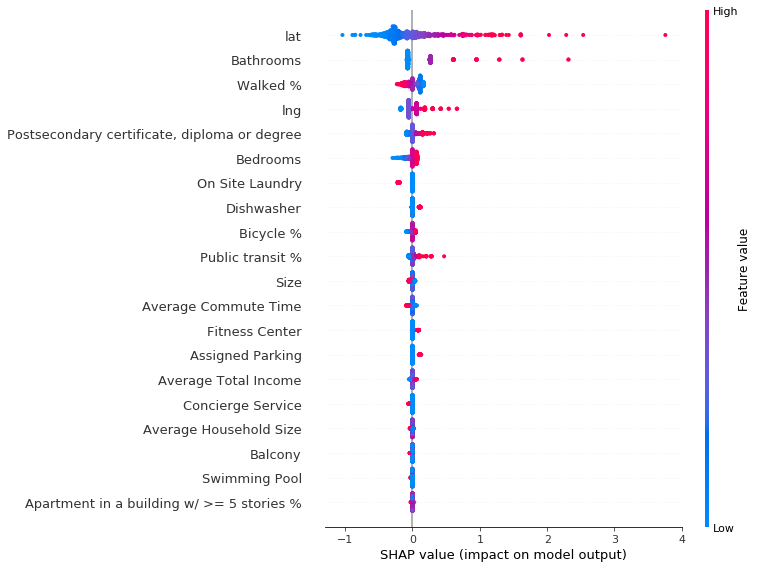

In [358]:
lr_ngb = NGBRegressor(Base=Ridge(), verbose=False)
lr_ngb.fit(train_X_clean, train_y)

# Summarize with a set of weighted kmeans
train_X_summ = shap.kmeans(train_X_clean, 10)

explainer = shap.KernelExplainer(lr_ngb.predict, train_X_summ, link='identity', model_output=0)
shap_values = explainer.shap_values(val_X_clean, l1_reg='num_features(10)')
shap.summary_plot(shap_values, val_X_clean)

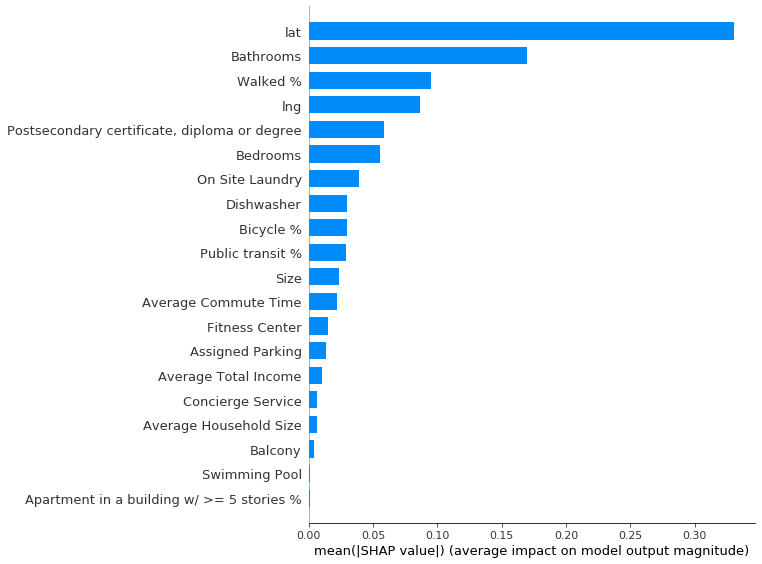

In [359]:
# Feature importance
shap.summary_plot(shap_values, val_X_clean, plot_type="bar")

In [360]:
# Predict on validation set
y_dists = lr_ngb.pred_dist(val_X_clean)
scores = -y_dists.logpdf(val_y)
top_3_idx = np.flip(np.argsort(scores))[:5]

# Instance with the worst score
idx = top_3_idx[0]
print('Predicted price: {:0.2f}, True price: {}'.format(y_dists[idx].params['loc'], val_y[idx]))
print(val_X.iloc[idx])

# Force plot
shap.force_plot(explainer.expected_value, shap_values[idx,:], val_X_clean.iloc[idx,:])

Predicted price: 6.07, True price: 26.0
lng                                                                            -79.429
lat                                                                            43.7487
Bedrooms                                                                             7
Bathrooms                                                                            8
Size                                                                               NaN
Balcony                                                                              0
Dishwasher                                                                           0
In Unit Laundry                                                                      0
On Site Laundry                                                                      0
Assigned Parking                                                                     0
Fitness Center                                                                       0
Gar

In [361]:
# Instance with the 2nd worst score
idx = top_3_idx[1]
print('Predicted price: {:0.2f}, True price: {}'.format(y_dists[idx].params['loc'], val_y[idx]))
print(val_X.iloc[idx])

# Force plot
shap.force_plot(explainer.expected_value, shap_values[idx,:], val_X_clean.iloc[idx,:])

Predicted price: 2.91, True price: 9.5
lng                                                                            -79.3871
lat                                                                             43.6453
Bedrooms                                                                              2
Bathrooms                                                                             2
Size                                                                                NaN
Balcony                                                                               0
Dishwasher                                                                            0
In Unit Laundry                                                                       0
On Site Laundry                                                                       0
Assigned Parking                                                                      0
Fitness Center                                                                   

In [362]:
# Instance with the 3rd worst score
idx = top_3_idx[2]
print('Predicted price: {:0.2f}, True price: {}'.format(y_dists[idx].params['loc'], val_y[idx]))
print(val_X.iloc[idx])

# Force plot
shap.force_plot(explainer.expected_value, shap_values[idx,:], val_X_clean.iloc[idx,:])

Predicted price: 2.94, True price: 9.5
lng                                                                           -79.3896
lat                                                                            43.6723
Bedrooms                                                                             1
Bathrooms                                                                            2
Size                                                                               NaN
Balcony                                                                              0
Dishwasher                                                                           0
In Unit Laundry                                                                      0
On Site Laundry                                                                      0
Assigned Parking                                                                     0
Fitness Center                                                                       0
Gara

#### Neural Network (Monte Carlo Dropout)

In [351]:
# Train the network
mcn = MCDropout(train_X_clean.shape[1], hidd_dim=50, drop_rate=0.2, tau=0.9)
mcn.fit(train_X_clean.to_numpy(), train_y, val_X=val_X_clean.to_numpy(), val_y=val_y, n_epochs=500)

Test loss at epoch [10/500]: 4574.7880859375
Test loss at epoch [20/500]: 2734.49755859375
Test loss at epoch [30/500]: 1695.753662109375
Test loss at epoch [40/500]: 1452.429443359375
Test loss at epoch [50/500]: 1246.027587890625
Test loss at epoch [60/500]: 1149.5443115234375
Test loss at epoch [70/500]: 1227.811767578125
Test loss at epoch [80/500]: 1323.741455078125
Test loss at epoch [90/500]: 1294.369140625
Test loss at epoch [100/500]: 1148.4713134765625
Test loss at epoch [110/500]: 1264.064697265625
Test loss at epoch [120/500]: 1318.7781982421875
Test loss at epoch [130/500]: 1208.88720703125
Test loss at epoch [140/500]: 1122.4637451171875
Test loss at epoch [150/500]: 1077.3321533203125
Test loss at epoch [160/500]: 1275.306884765625
Test loss at epoch [170/500]: 1327.31298828125
Test loss at epoch [180/500]: 1215.253173828125
Test loss at epoch [190/500]: 1352.8175048828125
Test loss at epoch [200/500]: 1126.322509765625
Test loss at epoch [210/500]: 1100.572021484375
Tes

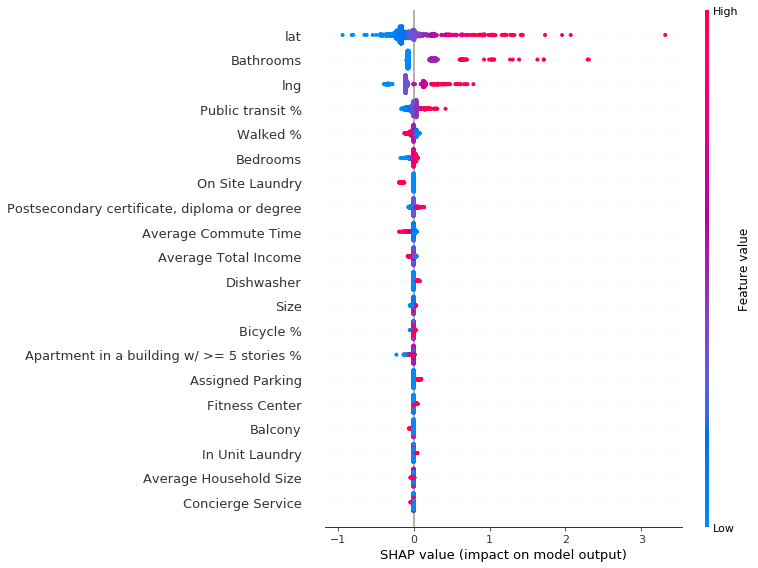

In [352]:
# Summarize with a set of weighted kmeans
train_X_summ = shap.kmeans(train_X_clean, 10)

explainer = shap.KernelExplainer(mcn._predict, train_X_summ, link='identity', model_output=0)
nn_shap_values = explainer.shap_values(val_X_clean, l1_reg='num_features(10)')
shap.summary_plot(nn_shap_values[0], val_X_clean)

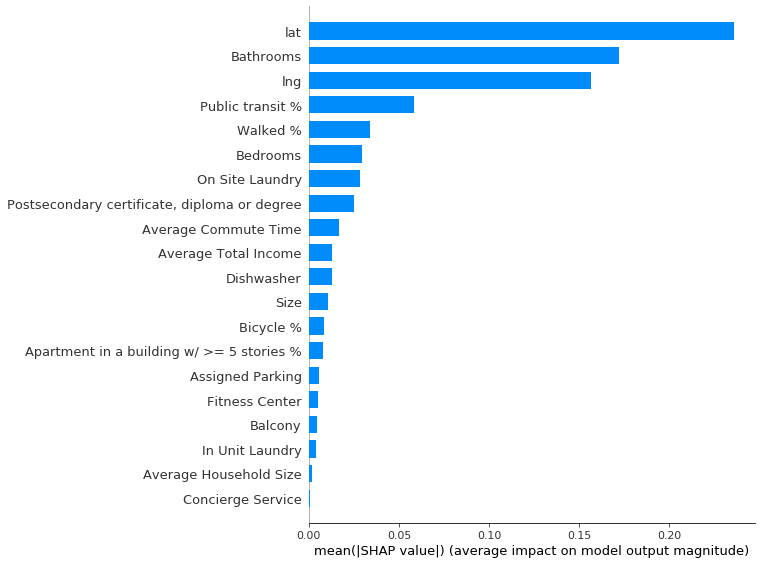

In [353]:
shap.summary_plot(nn_shap_values[0], val_X_clean, plot_type='bar')

In [354]:
# Predict on validation set
scores = mcn.negative_log_likelihood(val_X_clean.to_numpy(), val_y)
top_3_idx = np.flip(np.argsort(scores))[:5]

# Instance with the worst score
idx = top_3_idx[0]
print('Predicted price: {:0.2f}, True price: {}'.format(mcn.mc_predict(val_X_clean.to_numpy()[idx, :]).mean(), val_y[idx]))
print(val_X.iloc[idx])

# Force plot; for some reason nn_shap_values is a list with a single element
shap.force_plot(explainer.expected_value, nn_shap_values[0][idx,:], val_X_clean.iloc[idx,:])

Predicted price: 5.85, True price: 26.0
lng                                                                            -79.429
lat                                                                            43.7487
Bedrooms                                                                             7
Bathrooms                                                                            8
Size                                                                               NaN
Balcony                                                                              0
Dishwasher                                                                           0
In Unit Laundry                                                                      0
On Site Laundry                                                                      0
Assigned Parking                                                                     0
Fitness Center                                                                       0
Gar

In [355]:
# Instance with the 2nd worst score
idx = top_3_idx[1]
print('Predicted price: {:0.2f}, True price: {}'.format(mcn.mc_predict(val_X_clean.to_numpy()[idx, :]).mean(), val_y[idx]))
print(val_X.iloc[idx])

# Force plot; for some reason nn_shap_values is a list with a single element
shap.force_plot(explainer.expected_value, nn_shap_values[0][idx,:], val_X_clean.iloc[idx,:])

Predicted price: 5.84, True price: 21.9
lng                                                                          -79.3842
lat                                                                           43.7481
Bedrooms                                                                            5
Bathrooms                                                                           6
Size                                                                              NaN
Balcony                                                                             0
Dishwasher                                                                          0
In Unit Laundry                                                                     0
On Site Laundry                                                                     0
Assigned Parking                                                                    0
Fitness Center                                                                      0
Garage Parking

In [356]:
# Instance with the worst score
idx = top_3_idx[2]
print('Predicted price: {:0.2f}, True price: {}'.format(mcn.mc_predict(val_X_clean.to_numpy()[idx, :]).mean(), val_y[idx]))
print(val_X.iloc[idx])

# Force plot; for some reason nn_shap_values is a list with a single element
shap.force_plot(explainer.expected_value, nn_shap_values[0][idx,:], val_X_clean.iloc[idx,:])

Predicted price: 6.12, True price: 14.9
lng                                                                    -79.3729
lat                                                                     43.6834
Bedrooms                                                                      5
Bathrooms                                                                     5
Size                                                                        NaN
Balcony                                                                       0
Dishwasher                                                                    0
In Unit Laundry                                                               0
On Site Laundry                                                               0
Assigned Parking                                                              0
Fitness Center                                                                0
Garage Parking                                                                0


### Feature Engineering

It seems that latitude (and at times longitude) seems to generally contribute the most to changes in the model output. We can take a look at the change in predicted rent price as the listing's location changes:

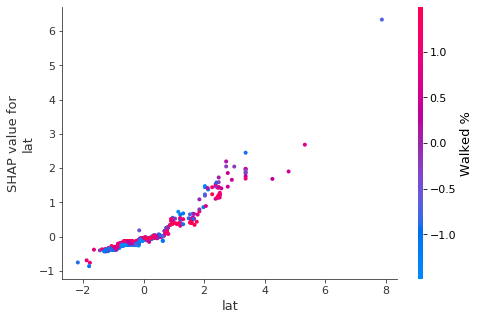

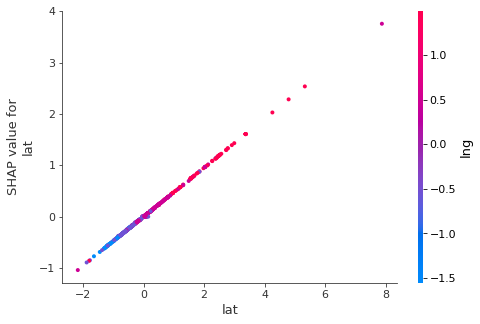

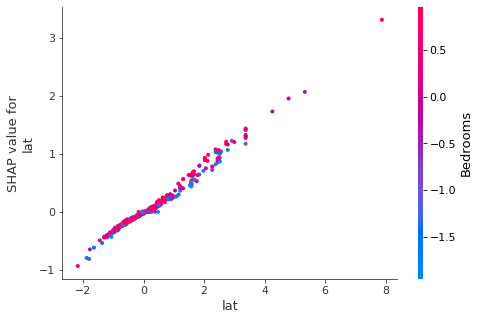

In [371]:
# NGBoost w/ Decision Tree Weak Learner
shap.dependence_plot("lat", dt_shap_values, val_X_clean)

# NGBoost w/ Ridge Regression Weak Learner
shap.dependence_plot("lat", shap_values, val_X_clean)

# Neural Network w/ Monte Carlo Dropout
shap.dependence_plot("lat", nn_shap_values[0], val_X_clean)

It seems that the models seem to suffer in listings with a larger number of bedrooms and bathrooms, tending to underestimate the rent price is these listings. In particular, the models seem to ignore the 'Bedrooms' attribute, even though they are one of the largest contributing factors in the large price increase. We can try multiplying or adding the Bedroom and Bathroom features (and drop the individual features) so that the model is forced to take both into consideration.

In [417]:
# New data pipeline

one_hot_attribs = [
    'Balcony', 
    'Dishwasher',
    'In Unit Laundry',
    'On Site Laundry',
    'Assigned Parking',
    'Fitness Center',
    'Garage Parking',
    'Storage',
    'Concierge Service',
    'Swimming Pool'
]

num_attribs = list(set(X_train.columns).difference(set(one_hot_attribs)))
    
class FeatureCombiner(BaseEstimator, TransformerMixin):
    
    def __init__(self, mul=True):
        self.multiply = mul
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.multiply:
            X['Bed*Bath'] = X['Bedrooms'] * X['Bathrooms']
        else:
            X['Bed+Bath'] = X['Bedrooms'] + X['Bathrooms']
        X = X.drop(['Bedrooms', 'Bathrooms'], axis=1)
        return X
    
num_pipeline = Pipeline([
    ('size_imputer', SizeImputer(n_neighbors=5)),
    ('bed+bath_combiner', FeatureCombiner(mul=True)),
    ('feature_dropper', FeatureDropper(
        dwellings=True, 
        education=True, 
        commute=True,
        pvt_dwellings=True, 
        m_age=True
    )),
    ('std_scaler', StandardScaler())
])

data_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', 'passthrough', one_hot_attribs)
])

X_train_final = data_pipeline.fit_transform(X_train)
# scores = {
#     'Multiple Regressors': {},
#     'NN w/ Monte Carlo Dropout': {},
#     'NGB w/ Decision Tree WL': {},
#     'NGB w/ Ridge Regression WL': {},
#     'Gaussian Process': {}
# }

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Now, let's retrain our models to check if there is an improvement:

In [387]:
dt_scores = []
rr_scores = []
nn_scores = []

# Convert to Pandas Series to numpy
# y_train = y_train.to_numpy()

# NGBoost w/ Decision Tree WL
for train, test in kf.split(X_train_final):
    ngb = NGBRegressor(verbose=False)
    ngb.fit(X_train_final[train, :], y_train[train])
    y_dists = ngb.pred_dist(X_train_final[test, :])
    score = -y_dists.logpdf(y_train[test]).mean()
    dt_scores.append(score)

dt_scores = np.asarray(dt_scores)
scores['NGB w/ Decision Tree WL'] = {
    'mean': dt_scores.mean(),
    'std': dt_scores.std()
}

# NGBoost w/ Ridge Regression WL
for train, test in kf.split(X_train_final):
    learner = Ridge()
    ngb = NGBRegressor(Base=learner, verbose=False)
    ngb.fit(X_train_final[train, :], y_train[train])
    y_dists = ngb.pred_dist(X_train_final[test, :])
    score = -y_dists.logpdf(y_train[test]).mean()
    rr_scores.append(score)

rr_scores = np.asarray(rr_scores)
scores['NGB w/ Ridge Regression WL'] = {
    'mean': rr_scores.mean(),
    'std': rr_scores.std()
}

# MLP w/ Monte Carlo Dropout
for train, test in kf.split(X_train_final):
    mcn = MCDropout(X_train_final.shape[1], hidd_dim=50, drop_rate=0.2, tau=0.9)
    mcn.fit(X_train_final[train, :], y_train[train], n_epochs=700)
    score = mcn.score(X_train_final[test, :], y_train[test], T=500)
    nn_scores.append(score)

nn_scores = np.asarray(nn_scores)
scores['NN w/ Monte Carlo Dropout'] = {
    'mean': nn_scores.mean(),
    'std': nn_scores.std()
}

print('NN w/ Monte Carlo Dropout: {:0.2f} +- {:0.2f}'.format(scores['NN w/ Monte Carlo Dropout']['mean'], scores['NN w/ Monte Carlo Dropout']['std']))
print('NGB w/ Decision Tree WL: {:0.2f} +- {:0.2f}'.format(scores['NGB w/ Decision Tree WL']['mean'], scores['NGB w/ Decision Tree WL']['std']))
print('NGB w/ Ridge Regression WL: {:0.2f} +- {:0.2f}'.format(scores['NGB w/ Ridge Regression WL']['mean'], scores['NGB w/ Ridge Regression WL']['std']))

overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square


NN w/ Monte Carlo Dropout: 1.20 +- 0.06
NGB w/ Decision Tree WL: 0.45 +- 0.07
NGB w/ Ridge Regression WL: 0.65 +- 0.07


In [389]:
X_cols = [
   'lng', 
   'lat', 
   'Size', 
   'Average Total Income', 
   'Average Household Size',
   'Average Commute Time', 
   'Public transit %', 
   'Walked %', 
   'Bicycle %',
   'Apartment in a building w/ >= 5 stories %',
   'Postsecondary certificate, diploma or degree',
   'Bed*Bath',
   'Balcony', 
   'Dishwasher',
   'In Unit Laundry', 
   'On Site Laundry', 
   'Assigned Parking',
   'Fitness Center', 
   'Garage Parking', 
   'Storage', 
   'Concierge Service',
   'Swimming Pool'
]

# Turn into DataFrame so that we can look at feature behaviours
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.1)
train_X_clean = pd.DataFrame(data_pipeline.fit_transform(train_X), columns=X_cols)
val_X_clean = pd.DataFrame(data_pipeline.fit_transform(val_X), columns=X_cols)

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Index(['Size', 'Postsecondary certificate, diploma or degree', 'geometry',
       'Secondary (high) school diploma or equivalent',
       'Apartment in a building w/ < 5 stories %', 'AREA_SHORT_CODE',
       'Walked %', 'Public transit %', 'Car, truck, van - as a driver %',
       'Average Household Size', 'lat', 'Median Age', 'AREA_NAME',
       'No certificate, diploma or degree', 'Row house %',
       'Single-detached house %', 'Apartment or flat in a duplex %',
       'Average Total Income', 'Average Commute Time',
       'Apartment in a building w/ >= 5 stories %', 'Semi-detached house %',
       'lng', 'Total private dwellings', 'Bicycle %', 'index_right',
       'Car, truck, van - as a passenger %', 'Bed+Bath'],
      dtype='object')
Index(['Size', 'Postsecondary certificate, diploma or degree', 'geometry',
       'Secondary (high) school diploma or equivalent',
       'Apartment in a building w/ < 5 stories %', 'AREA_SHORT_CODE',
       'Walked %', 'Public transit %', 'Car, tru

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


overflow encountered in square
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


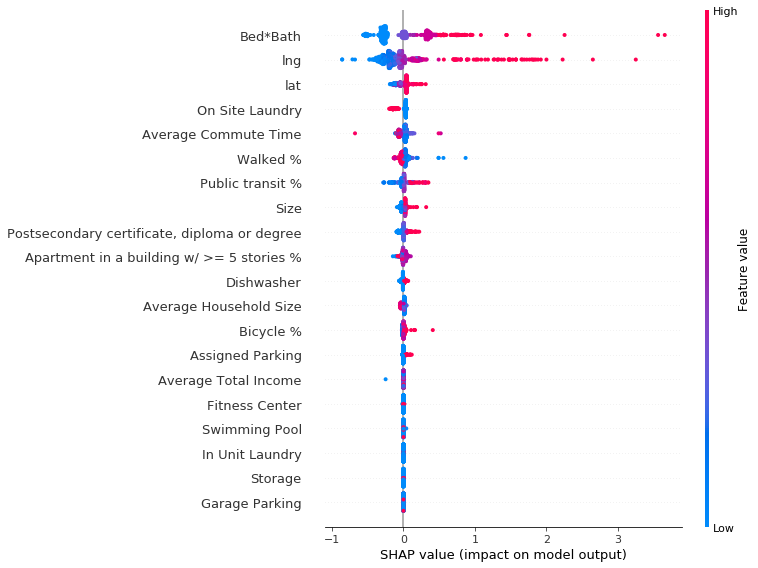

In [390]:
shap.initjs()

ngb = NGBRegressor(verbose=False)
ngb.fit(train_X_clean, train_y)

explainer = shap.TreeExplainer(ngb, model_output=0)
dt_shap_values = explainer.shap_values(val_X_clean)
shap.summary_plot(dt_shap_values, val_X_clean)

In [391]:
# Predict on validation set
y_dists = ngb.pred_dist(val_X_clean)
scores = -y_dists.logpdf(val_y)
top_3_idx = np.flip(np.argsort(scores))[:5]

# Instance with the worst score
idx = top_3_idx[0]
print('Predicted price: {:0.2f}, True price: {}'.format(y_dists[idx].params['loc'], val_y[idx]))
print(val_X.iloc[idx])

# Force plot
shap.force_plot(explainer.expected_value, dt_shap_values[idx,:], val_X_clean.iloc[idx,:])

Predicted price: 3.11, True price: 9.5
lng                                                                           -79.3804
lat                                                                            43.6497
Bedrooms                                                                             2
Bathrooms                                                                            2
Size                                                                               NaN
Balcony                                                                              0
Dishwasher                                                                           0
In Unit Laundry                                                                      0
On Site Laundry                                                                      0
Assigned Parking                                                                     0
Fitness Center                                                                       0
Gara

In [392]:
# Instance with the 2nd worst score
idx = top_3_idx[1]
print('Predicted price: {:0.2f}, True price: {}'.format(y_dists[idx].params['loc'], val_y[idx]))
print(val_X.iloc[idx])

# Force plot
shap.force_plot(explainer.expected_value, dt_shap_values[idx,:], val_X_clean.iloc[idx,:])

Predicted price: 2.29, True price: 4.699
lng                                                                    -79.3839
lat                                                                     43.6619
Bedrooms                                                                      2
Bathrooms                                                                     1
Size                                                                        NaN
Balcony                                                                       1
Dishwasher                                                                    0
In Unit Laundry                                                               0
On Site Laundry                                                               1
Assigned Parking                                                              0
Fitness Center                                                                1
Garage Parking                                                                0

In [406]:
# Instance with the 3rd worst score
top_3_idx = np.flip(np.argsort(scores))
idx = top_3_idx[20]
print('Predicted price: {:0.2f}, True price: {}'.format(y_dists[idx].params['loc'], val_y[idx]))
print(val_X.iloc[idx])

# Force plot
shap.force_plot(explainer.expected_value, dt_shap_values[idx,:], val_X_clean.iloc[idx,:])

Predicted price: 2.34, True price: 3.05
lng                                                                           -79.2777
lat                                                                            43.7852
Bedrooms                                                                             2
Bathrooms                                                                            2
Size                                                                               NaN
Balcony                                                                              0
Dishwasher                                                                           0
In Unit Laundry                                                                      0
On Site Laundry                                                                      0
Assigned Parking                                                                     0
Fitness Center                                                                       0
Gar

So as we can see, the model no longer makes mistakes on listings that have a lot of bedrooms or bathrooms. Instead, it seems to make mistakes on outliers; it underestimates the rent on listings that are listed way above market value for that type of unit. Let's try training our models with a different combined feature term:

In [410]:
num_pipeline = Pipeline([
    ('size_imputer', SizeImputer(n_neighbors=5)),
    ('bed+bath_combiner', FeatureCombiner(mul=False)),
    ('feature_dropper', FeatureDropper(
        dwellings=True, 
        education=True, 
        commute=True,
        pvt_dwellings=True, 
        m_age=True
    )),
    ('std_scaler', StandardScaler())
])

data_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', 'passthrough', one_hot_attribs)
])

X_train_final = data_pipeline.fit_transform(X_train)
scores = {
    'Multiple Regressors': {},
    'NN w/ Monte Carlo Dropout': {},
    'NGB w/ Decision Tree WL': {},
    'NGB w/ Ridge Regression WL': {},
    'Gaussian Process': {}
}

dt_scores = []
rr_scores = []
nn_scores = []

# Convert to Pandas Series to numpy
# y_train = y_train.to_numpy()

# NGBoost w/ Decision Tree WL
for train, test in kf.split(X_train_final):
    ngb = NGBRegressor(verbose=False)
    ngb.fit(X_train_final[train, :], y_train[train])
    y_dists = ngb.pred_dist(X_train_final[test, :])
    score = -y_dists.logpdf(y_train[test]).mean()
    dt_scores.append(score)

dt_scores = np.asarray(dt_scores)
scores['NGB w/ Decision Tree WL'] = {
    'mean': dt_scores.mean(),
    'std': dt_scores.std()
}

# NGBoost w/ Ridge Regression WL
for train, test in kf.split(X_train_final):
    learner = Ridge()
    ngb = NGBRegressor(Base=learner, verbose=False)
    ngb.fit(X_train_final[train, :], y_train[train])
    y_dists = ngb.pred_dist(X_train_final[test, :])
    score = -y_dists.logpdf(y_train[test]).mean()
    rr_scores.append(score)

rr_scores = np.asarray(rr_scores)
scores['NGB w/ Ridge Regression WL'] = {
    'mean': rr_scores.mean(),
    'std': rr_scores.std()
}

# MLP w/ Monte Carlo Dropout
for train, test in kf.split(X_train_final):
    mcn = MCDropout(X_train_final.shape[1], hidd_dim=50, drop_rate=0.2, tau=0.9)
    mcn.fit(X_train_final[train, :], y_train[train], n_epochs=700)
    score = mcn.score(X_train_final[test, :], y_train[test], T=500)
    nn_scores.append(score)

nn_scores = np.asarray(nn_scores)
scores['NN w/ Monte Carlo Dropout'] = {
    'mean': nn_scores.mean(),
    'std': nn_scores.std()
}

print('NN w/ Monte Carlo Dropout: {:0.2f} +- {:0.2f}'.format(scores['NN w/ Monte Carlo Dropout']['mean'], scores['NN w/ Monte Carlo Dropout']['std']))
print('NGB w/ Decision Tree WL: {:0.2f} +- {:0.2f}'.format(scores['NGB w/ Decision Tree WL']['mean'], scores['NGB w/ Decision Tree WL']['std']))
print('NGB w/ Ridge Regression WL: {:0.2f} +- {:0.2f}'.format(scores['NGB w/ Ridge Regression WL']['mean'], scores['NGB w/ Ridge Regression WL']['std']))

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Index(['Size', 'Postsecondary certificate, diploma or degree', 'geometry',
       'Secondary (high) school diploma or equivalent',
       'Apartment in a building w/ < 5 stories %', 'AREA_SHORT_CODE',
       'Walked %', 'Public transit %', 'Car, truck, van - as a driver %',
       'Average Household Size', 'lat', 'Median Age', 'AREA_NAME',
       'No certificate, diploma or degree', 'Row house %',
       'Single-detached house %', 'Apartment or flat in a duplex %',
       'Average Total Income', 'Average Commute Time',
       'Apartment in a building w/ >= 5 stories %', 'Semi-detached house %',
       'lng', 'Total private dwellings', 'Bicycle %', 'index_right',
       'Car, truck, van - as a passenger %', 'Bed+Bath'],
      dtype='object')


overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square


NN w/ Monte Carlo Dropout: 1.20 +- 0.06
NGB w/ Decision Tree WL: 0.45 +- 0.07
NGB w/ Ridge Regression WL: 0.65 +- 0.07


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
overflow encountered in square
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


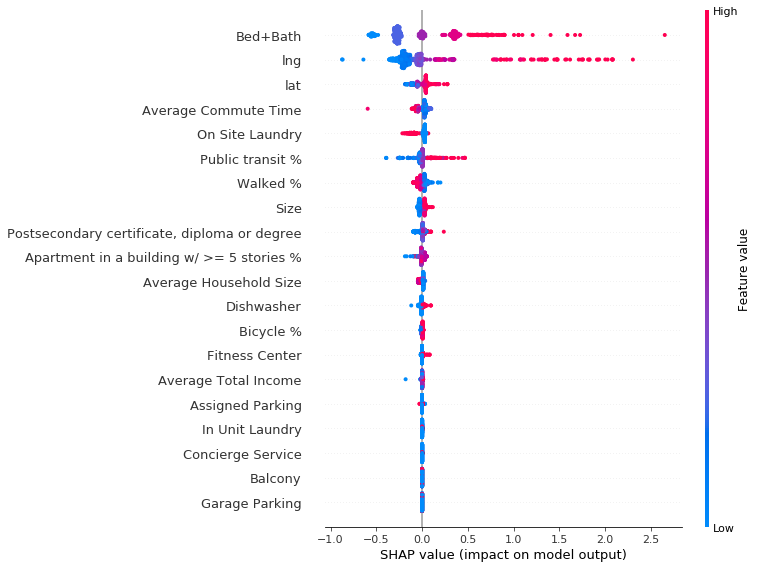

In [418]:
X_cols = [
   'lng', 
   'lat', 
   'Size', 
   'Average Total Income', 
   'Average Household Size',
   'Average Commute Time', 
   'Public transit %', 
   'Walked %', 
   'Bicycle %',
   'Apartment in a building w/ >= 5 stories %',
   'Postsecondary certificate, diploma or degree',
   'Bed+Bath',
   'Balcony', 
   'Dishwasher',
   'In Unit Laundry', 
   'On Site Laundry', 
   'Assigned Parking',
   'Fitness Center', 
   'Garage Parking', 
   'Storage', 
   'Concierge Service',
   'Swimming Pool'
]

# Turn into DataFrame so that we can look at feature behaviours
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.1)
train_X_clean = pd.DataFrame(data_pipeline.fit_transform(train_X), columns=X_cols)
val_X_clean = pd.DataFrame(data_pipeline.fit_transform(val_X), columns=X_cols)

ngb = NGBRegressor(verbose=False)
ngb.fit(train_X_clean, train_y)

explainer = shap.TreeExplainer(ngb, model_output=0)
dt_shap_values = explainer.shap_values(val_X_clean)
shap.summary_plot(dt_shap_values, val_X_clean)

In [427]:
# Predict on validation set
y_dists = ngb.pred_dist(val_X_clean)
scores = -y_dists.logpdf(val_y)
top_3_idx = np.flip(np.argsort(scores))

# Instance with the worst score
idx = top_3_idx[0]
print('Predicted price: {:0.2f}, True price: {}'.format(y_dists[idx].params['loc'], val_y[idx]))
print(val_X.iloc[idx])

# Force plot
shap.force_plot(explainer.expected_value, dt_shap_values[idx,:], val_X_clean.iloc[idx,:])

Predicted price: 4.19, True price: 14.5
lng                                                                    -79.3939
lat                                                                     43.6725
Bedrooms                                                                      3
Bathrooms                                                                     2
Size                                                                        NaN
Balcony                                                                       0
Dishwasher                                                                    1
In Unit Laundry                                                               1
On Site Laundry                                                               0
Assigned Parking                                                              1
Fitness Center                                                                0
Garage Parking                                                                0


In [429]:
# Instance with the 2nd worst score
idx = top_3_idx[6]
print('Predicted price: {:0.2f}, True price: {}'.format(y_dists[idx].params['loc'], val_y[idx]))
print(val_X.iloc[idx])

# Force plot
shap.force_plot(explainer.expected_value, dt_shap_values[idx,:], val_X_clean.iloc[idx,:])

Predicted price: 5.73, True price: 10.9
lng                                                                                  -79.3969
lat                                                                                   43.6756
Bedrooms                                                                                    3
Bathrooms                                                                                   3
Size                                                                                      NaN
Balcony                                                                                     1
Dishwasher                                                                                  1
In Unit Laundry                                                                             1
On Site Laundry                                                                             0
Assigned Parking                                                                            1
Fitness Center      

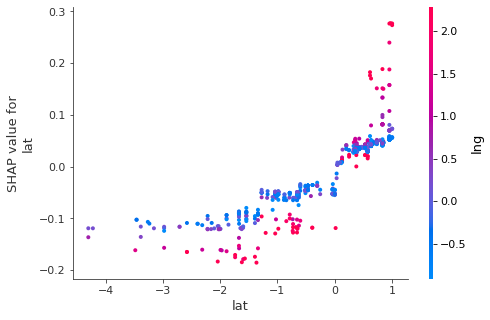

In [432]:
# NGBoost w/ Decision Tree Weak Learner
shap.dependence_plot("lat", dt_shap_values, val_X_clean)

Let's test the effect of the listing amenities coded variables by creating a random dummy variable of 0s and 1s (i.e., $x_i \sim \text{Bernoulli}(0.5)$ for $i = 1, \dots N$), and checking if this variable contributes a greater share to the model output than the listing amenities. If the model does find that some of the listing amenities are less important than the random feature, we should probably remove them.

In [455]:
from numpy.random import binomial

binomial(n=1, p=0.5, size=10)

one_hot_attribs = [
    'Balcony', 
    'Dishwasher',
    'In Unit Laundry',
    'On Site Laundry',
    'Assigned Parking',
    'Fitness Center',
    'Garage Parking',
    'Storage',
    'Concierge Service',
    'Swimming Pool',
]

num_attribs = list(set(X_train.columns).difference(set(one_hot_attribs)))
    
class RandomDummy(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        num_samples = X.shape[0]
        X['Random'] = np.random.binomial(n=1, p=0.5, size=num_samples)
        return X

num_pipeline = Pipeline([
    ('size_imputer', SizeImputer(n_neighbors=5)),
    ('bed+bath_combiner', FeatureCombiner(mul=True)),
    ('feature_dropper', FeatureDropper(
        dwellings=True, 
        education=True, 
        commute=True,
        pvt_dwellings=True, 
        m_age=True
    )),
    ('std_scaler', StandardScaler())
])

data_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', RandomDummy(), one_hot_attribs)
])

X_train_final = data_pipeline.fit_transform(X_train)

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


In [471]:
scores = {
    'Multiple Regressors': {},
    'NN w/ Monte Carlo Dropout': {},
    'NGB w/ Decision Tree WL': {},
    'NGB w/ Ridge Regression WL': {},
    'Gaussian Process': {}
}

dt_scores = []
rr_scores = []
nn_scores = []

# Convert to Pandas Series to numpy
# y_train = y_train.to_numpy()

# NGBoost w/ Decision Tree WL
for train, test in kf.split(X_train_final):
    ngb = NGBRegressor(verbose=False)
    ngb.fit(X_train_final[train, :], y_train[train])
    y_dists = ngb.pred_dist(X_train_final[test, :])
    score = -y_dists.logpdf(y_train[test]).mean()
    dt_scores.append(score)

dt_scores = np.asarray(dt_scores)
scores['NGB w/ Decision Tree WL'] = {
    'mean': dt_scores.mean(),
    'std': dt_scores.std()
}

# NGBoost w/ Ridge Regression WL
for train, test in kf.split(X_train_final):
    learner = Ridge()
    ngb = NGBRegressor(Base=learner, verbose=False)
    ngb.fit(X_train_final[train, :], y_train[train])
    y_dists = ngb.pred_dist(X_train_final[test, :])
    score = -y_dists.logpdf(y_train[test]).mean()
    rr_scores.append(score)

rr_scores = np.asarray(rr_scores)
scores['NGB w/ Ridge Regression WL'] = {
    'mean': rr_scores.mean(),
    'std': rr_scores.std()
}

# MLP w/ Monte Carlo Dropout
for train, test in kf.split(X_train_final):
    mcn = MCDropout(X_train_final.shape[1], hidd_dim=50, drop_rate=0.2, tau=0.9)
    mcn.fit(X_train_final[train, :], y_train[train], n_epochs=700)
    score = mcn.score(X_train_final[test, :], y_train[test], T=500)
    nn_scores.append(score)

nn_scores = np.asarray(nn_scores)
scores['NN w/ Monte Carlo Dropout'] = {
    'mean': nn_scores.mean(),
    'std': nn_scores.std()
}

print('NN w/ Monte Carlo Dropout: {:0.2f} +- {:0.2f}'.format(scores['NN w/ Monte Carlo Dropout']['mean'], scores['NN w/ Monte Carlo Dropout']['std']))
print('NGB w/ Decision Tree WL: {:0.2f} +- {:0.2f}'.format(scores['NGB w/ Decision Tree WL']['mean'], scores['NGB w/ Decision Tree WL']['std']))
print('NGB w/ Ridge Regression WL: {:0.2f} +- {:0.2f}'.format(scores['NGB w/ Ridge Regression WL']['mean'], scores['NGB w/ Ridge Regression WL']['std']))

overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square


NN w/ Monte Carlo Dropout: 1.20 +- 0.06
NGB w/ Decision Tree WL: 0.45 +- 0.07
NGB w/ Ridge Regression WL: 0.65 +- 0.07


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
overflow encountered in square
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


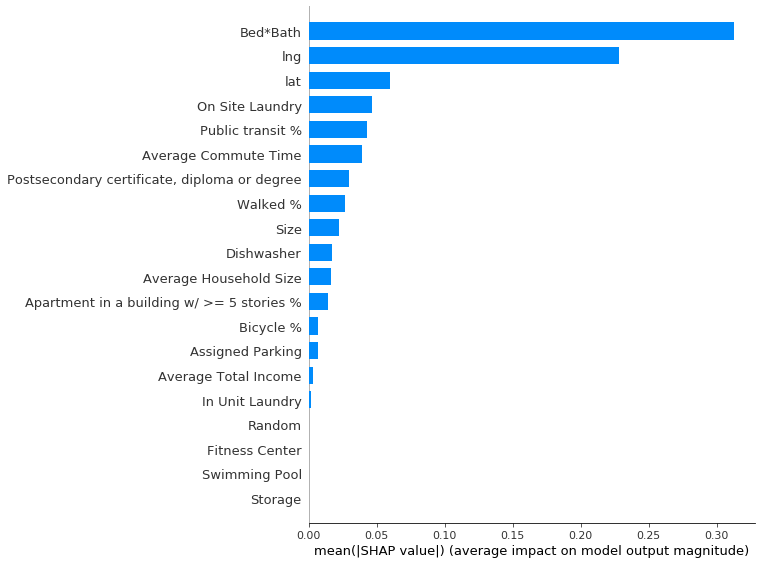

In [456]:
X_cols = [
   'lng', 
   'lat', 
   'Size', 
   'Average Total Income', 
   'Average Household Size',
   'Average Commute Time', 
   'Public transit %', 
   'Walked %', 
   'Bicycle %',
   'Apartment in a building w/ >= 5 stories %',
   'Postsecondary certificate, diploma or degree',
   'Bed+Bath',
   'Balcony', 
   'Dishwasher',
   'In Unit Laundry', 
   'On Site Laundry', 
   'Assigned Parking',
   'Fitness Center', 
   'Garage Parking', 
   'Storage', 
   'Concierge Service',
   'Swimming Pool',
   'Random'
]

# Turn into DataFrame so that we can look at feature behaviours
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.1)
train_X_clean = pd.DataFrame(data_pipeline.fit_transform(train_X), columns=X_cols)
val_X_clean = pd.DataFrame(data_pipeline.fit_transform(val_X), columns=X_cols)

ngb = NGBRegressor(verbose=False)
ngb.fit(train_X_clean, train_y)

explainer = shap.TreeExplainer(ngb, model_output=0)
dt_shap_values = explainer.shap_values(val_X_clean)
shap.summary_plot(dt_shap_values, val_X_clean, plot_type='bar')

It seems that the listing amenities 'Fitness Center', 'Swimming Pool', and 'Storage' contribute less to the model than the feature of random 0s and 1s. This suggests that we should take these features out.

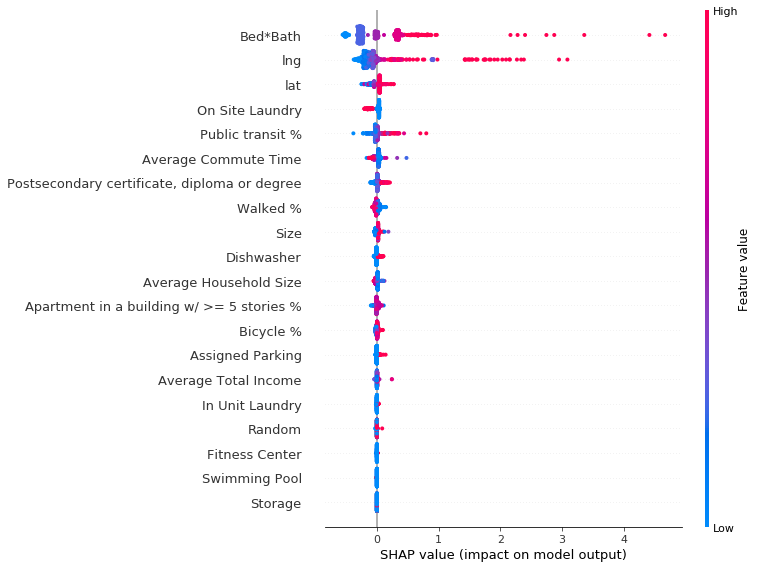

In [457]:
shap.summary_plot(dt_shap_values, val_X_clean)

In [460]:
one_hot_attribs = [
    'Balcony', 
    'Dishwasher',
    'In Unit Laundry',
    'On Site Laundry',
    'Assigned Parking',
    'Fitness Center',
    'Garage Parking',
    'Storage',
    'Concierge Service',
    'Swimming Pool',
]

training_set[one_hot_attribs].mean()

Balcony              0.201699
Dishwasher           0.265229
In Unit Laundry      0.228105
On Site Laundry      0.181046
Assigned Parking     0.135294
Fitness Center       0.184967
Garage Parking       0.151242
Storage              0.118170
Concierge Service    0.142745
Swimming Pool        0.122353
dtype: float64

Since the effect of each listing amenity is at best random ('On Site Laundry' actually contributes negative shap values when it is present in a listing) and is usually very small, we choose to remove them. In a revised run, we can estimate listing amenities effects however we need a better methodology for collecting them in the future (possibly picking out amenities from listing descriptions).

In [500]:
one_hot_attribs = [
    'Balcony', 
    'Dishwasher',
    'In Unit Laundry',
    'On Site Laundry',
    'Assigned Parking',
    'Garage Parking',
    'Concierge Service',
]

num_pipeline = Pipeline([
    ('size_imputer', SizeImputer(n_neighbors=5)),
    ('bed+bath_combiner', FeatureCombiner(mul=True)),
    ('feature_dropper', FeatureDropper(
        dwellings=True, 
        education=True, 
        commute=True,
        pvt_dwellings=True, 
        m_age=True
    )),
    ('std_scaler', StandardScaler())
])

data_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', 'passthrough', one_hot_attribs)
])

X_train_final = data_pipeline.fit_transform(X_train)

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
overflow encountered in square
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


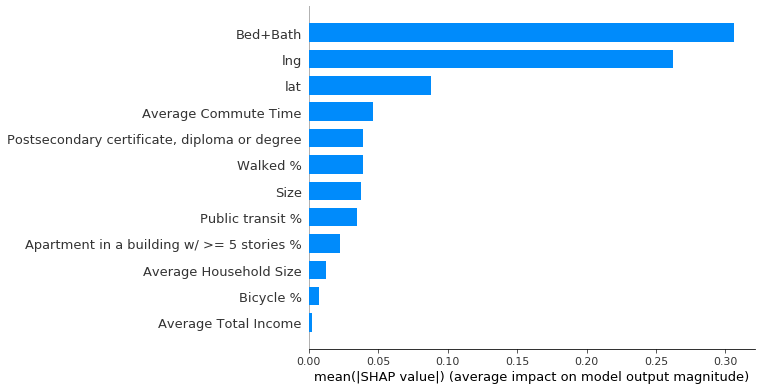

In [464]:
X_cols = [
   'lng', 
   'lat', 
   'Size', 
   'Average Total Income', 
   'Average Household Size',
   'Average Commute Time', 
   'Public transit %', 
   'Walked %', 
   'Bicycle %',
   'Apartment in a building w/ >= 5 stories %',
   'Postsecondary certificate, diploma or degree',
   'Bed+Bath',
]

# Turn into DataFrame so that we can look at feature behaviours
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.1)
train_X_clean = pd.DataFrame(data_pipeline.fit_transform(train_X), columns=X_cols)
val_X_clean = pd.DataFrame(data_pipeline.fit_transform(val_X), columns=X_cols)

ngb = NGBRegressor(verbose=False)
ngb.fit(train_X_clean, train_y)

explainer = shap.TreeExplainer(ngb, model_output=0)
dt_shap_values = explainer.shap_values(val_X_clean)
shap.summary_plot(dt_shap_values, val_X_clean, plot_type='bar')

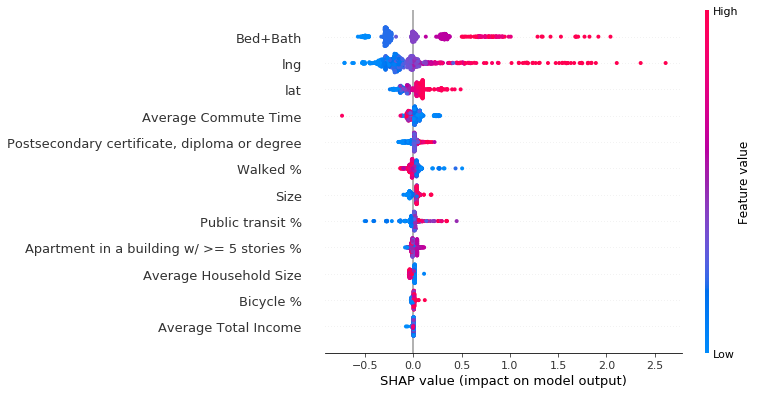

In [465]:
shap.summary_plot(dt_shap_values, val_X_clean)

In [468]:
# Predict on validation set
y_dists = ngb.pred_dist(val_X_clean)
scores = -y_dists.logpdf(val_y)
top_3_idx = np.flip(np.argsort(scores))

# Instance with the worst score
idx = top_3_idx[2]
print('Predicted price: {:0.2f}, True price: {}'.format(y_dists[idx].params['loc'], val_y[idx]))
print(val_X.iloc[idx])

# Force plot
shap.force_plot(explainer.expected_value, dt_shap_values[idx,:], val_X_clean.iloc[idx,:])

Predicted price: 2.03, True price: 4.999
lng                                                                    -79.3371
lat                                                                     43.6732
Bedrooms                                                                      2
Bathrooms                                                                     2
Size                                                                        200
Balcony                                                                       0
Dishwasher                                                                    1
In Unit Laundry                                                               0
On Site Laundry                                                               1
Assigned Parking                                                              1
Fitness Center                                                                0
Garage Parking                                                                0

In [502]:
kp_mat.iloc[0]

lng                                                                             -79.394
lat                                                                             43.6411
Size                                                                                550
Bedrooms                                                                              1
Bathrooms                                                                             1
Balcony                                                                               1
In Unit Laundry                                                                       1
On Site Laundry                                                                       0
Fitness Center                                                                        1
Garage Parking                                                                        1
Storage                                                                               0
Dishwasher                      

In [516]:
kuyas_place = pd.DataFrame({
    'lng': [-79.210992],
    'lat': [43.774243],
    'Bedrooms': [1.],
    'Bathrooms': [1.],
    'Size': [550],
    'Balcony': [0],
    'Dishwasher': [1],
    'In Unit Laundry': [1],
    'On Site Laundry': [0],
    'Assigned Parking': [0],
    'Fitness Center': [0],
    'Garage Parking': [1],
    'Storage': [0],
    'Concierge Service': [0],
    'Swimming Pool': [1]
                           })

# Convert to rent data to geopandas df so we can use spatial join 
kp_geo = gpd.GeoDataFrame(
    kuyas_place, geometry=gpd.points_from_xy(kuyas_place.lng, kuyas_place.lat))
# rent_df_geo = rent_df_geo[rent_df_geo['lat'].notna()] # Remove points that have no coordinates
kp_geo.set_crs(epsg=4326)

# Join on geometry
kp_mat = gpd.sjoin(kp_geo, nbhd_df, how='left')

kp_mat = kp_mat[[c for c in kp_mat if c not in ['geometry']] 
       + ['geometry']]

# kp_mat.iloc[0]
kp = data_pipeline.transform(kp_mat)


CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326



In [517]:
ngb_pt = NGBRegressor(verbose=False)
ngb_pt.fit(X_train_final, y_train)
kp_pred = ngb_pt.pred_dist(kp)

overflow encountered in square


In [519]:
mu, sigma = kp_pred.params['loc'], kp_pred.params['scale']
print(f'Mean: {mu}, Std.: {sigma}')

Mean: [1.79633734], Std.: [0.3011887]


### **Hyperparameter Tuning**


#### Natural Gradient Boost (w/ Decision Tree Weak Learner)